# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

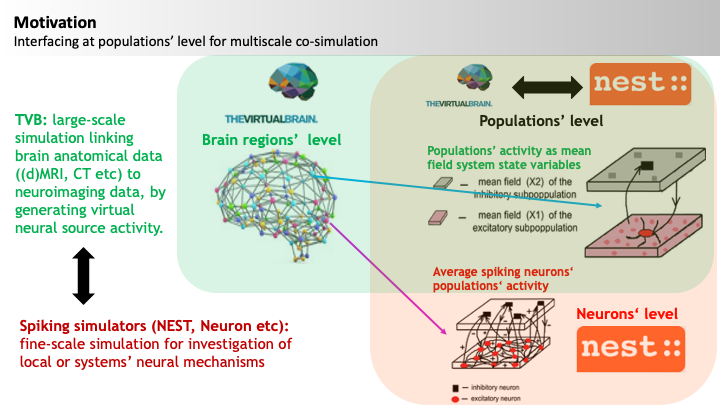

In [1]:
from IPython.core.display import Image, display
display(Image(filename='../pics/ConceptGraph1.png',  width=1000, unconfined=False))

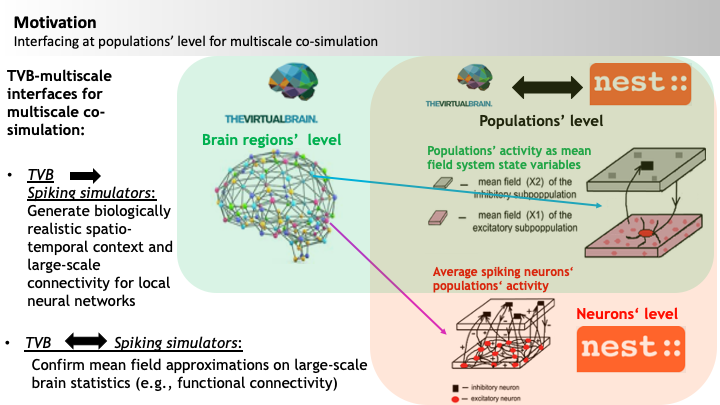

In [2]:
display(Image(filename='../pics/ConceptGraph2.png',  width=1000, unconfined=False))

## tvb-multiscale toolbox:

### https://github.com/the-virtual-brain/tvb-multiscale

For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@charite.de

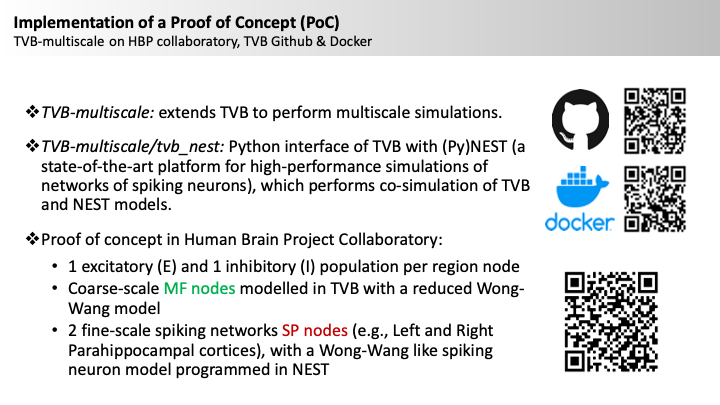

In [3]:
display(Image(filename='../pics/Overview.png',  width=1000, unconfined=False))

# TVB - NEST co-simulation 

## Linear TVB mean field model

For every region node $n\prime$ modelled as a mean-field node in TVB:

(Post)Synaptic gating dynamics (i.e., proportion of synapse channels open at any given time):

$\dot{R_{n\prime}} =  (\gamma{R_{n\prime}}(t) + {\sum_{{m\prime}\neq {n\prime}}C_{{m\prime}{n\prime}}R_{m\prime}(t-\tau_{{m\prime}{n\prime}})}(t))$


## Cerebellum Spiking network model in NEST

To be filled in!...

## TVB to NEST coupling
TVB couples to NEST via instantaneous spike rate $ interface_{weight} * R(t) $, 

Spike generator NEST devices are used as TVB "proxy" nodes and generate spike trains 

$ \left[ \sum_k \delta(t-\tau_{n\prime n}-{t_j}^k) \right]_{j \in n\prime} $



## NEST to TVB update

A NEST spike detector device is used to count spike for each time step, and convert it to an instantaneous population mean rate that overrides

$ {R_{_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in R_n}}{nNeurons * dt} $ in  spikes/sec.

This update process concerns only the TVB region nodes that are simulated exclusively in NEST, as spiking networks. All the rest of TVB nodes will follow the equations of the mean field model described above.


## Simulator loop

### Simulating several (i.e., 4) NEST time steps for every 1 TVB time step for stable integration

# WORKFLOW:

In [4]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *

# ----------- Simulation options ----------------
CEREB_TO_REST_OF_BRAIN_CONNS_SCALE = 100

SIM_MODE = "tvb-nest"
if SIM_MODE.lower() == "nest":
    BACKGROUND = True
else:
    BACKGROUND = False 
STIMULUS = False
NEST_MODEL_BUILDERS = True

WHOLE_BRAIN = True
# -----------------------------------------------

if WHOLE_BRAIN:
    BRAIN_CONN_FILE = "Connectivity_res100_596_regions.h5"
    G = 0.5
else:
    BRAIN_CONN_FILE = "Connectivity_res100_summ49regions_IOsplit.h5"
    G = 4.0  
    
work_path = os.getcwd()
data_path = os.path.join(work_path.split("tvb_nest")[0], "data", "cerebellum")
tvb_conn_filepath = os.path.join(data_path, BRAIN_CONN_FILE)
outputs_path = os.path.join(work_path, "outputs/cereb")
if NEST_MODEL_BUILDERS is False:
    outputs_path += "NoNestBuilders"
if STIMULUS:
    outputs_path += "Stim"
else:
    outputs_path += "Rest"
if SIM_MODE.lower() == "nest":
    outputs_path += "NESTonly"
elif SIM_MODE.lower() == "tvb":
    outputs_path += "TVBonly"
    
config = Config(output_base=outputs_path)
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

2021-09-28 19:16:15,673 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2021-09-28 19:16:15,673 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2021-09-28 19:16:15,676 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2021-09-28 19:16:15,676 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2021-09-28 19:16:15,678 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2021-09-28 19:16:15,678 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2021-09-28 19:16:15,681 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2021-09-28 19:16:15,681 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2021-09-28 19:16:15,685 - INFO - tvb_multiscale.tv

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

In [5]:
from tvb_multiscale.core.tvb.cosimulator.models.linear import Linear
from tvb.datatypes.connectivity import Connectivity
from tvb_multiscale.core.tvb.cosimulator.cosimulator_serial import CoSimulatorSerial
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG


# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = CoSimulatorSerial()
model_params = {"tau": np.array([10.0]), "gamma": np.array([-1.0]),
                "G": np.array([G]), # 0.25 (4.0) for whole (merged) connectome, 
                "I_o": np.array([1.0])}

simulator.model = Linear(**model_params)

simulator.integrator = HeunStochastic()
simulator.integrator.dt = 0.1
simulator.integrator.noise.nsig = np.array([config.DEFAULT_NSIG]) # 0.001


# Load connectivity
# config.DEFAULT_CONNECTIVITY_ZIP = "/home/docker/packages/tvb_data/tvb_data/mouse/allen_2mm/ConnectivityAllen2mm.zip"                                  
# connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)
import h5py
f = h5py.File(tvb_conn_filepath)
connectivity = Connectivity(weights=np.array(f["weights"][()]), tract_lengths=np.array(f["tract_lengths"][()]), 
                            centres=np.array(f["centres"][()]), # hemispheres=np.array(f["hemispheres"][()]), 
                            region_labels=np.array(f["region_labels"][()]).astype("<U128"))
f.close()

# Normalize connectivity weights
connectivity.weights[np.isnan(connectivity.weights)] = 0.0
connectivity.weights = connectivity.scaled_weights(mode="region")
connectivity.weights /= np.percentile(connectivity.weights, 99)
# connectivity.weights[connectivity.weights > 1.0] = 1.0

connectivity.tract_lengths = np.maximum(connectivity.speed * simulator.integrator.dt, 
                                        connectivity.tract_lengths)

connectivity.configure()

simulator.connectivity = connectivity

simulator.model.I_o = simulator.model.I_o[0] * np.ones((connectivity.number_of_regions, ))

simulator.initial_conditions = np.zeros((1, 1, connectivity.number_of_regions, 1))

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )

simulator.configure()

# plotter.plot_tvb_connectivity(simulator.connectivity);

In [6]:
# Select the regions for the fine scale modeling with NEST spiking networks
ordered_populations_labels = ['mossy_fibers', 'glomerulus', "granule_cell", "golgi_cell",
                              'io_cell', "basket_cell", "stellate_cell", "purkinje_cell",
                              'dcn_cell_GABA', 'dcn_cell_Gly-I', 'dcn_cell_glut_large']

region_labels = connectivity.region_labels.tolist()

cereberal_cortex = "Ansiform lobule"
inferior_olive = "Inferior olivary complex" 
cereberal_nucleus = "Interposed nucleus"

hemisphere = "Right"
cereberal_cortex = "%s %s" % (hemisphere, cereberal_cortex)
inferior_olive = "%s %s" % (hemisphere, inferior_olive)
cereberal_nucleus = "%s %s" % (hemisphere, cereberal_nucleus)
cereb_ctx_id = region_labels.index(cereberal_cortex)
pops_to_nodes_inds = dict(zip(ordered_populations_labels, [cereb_ctx_id] * len(ordered_populations_labels)))
io_ctx_id = region_labels.index(inferior_olive)
pops_to_nodes_inds['io_cell'] = io_ctx_id
dcn_cells = ['dcn_cell_GABA', 'dcn_cell_Gly-I', 'dcn_cell_glut_large']
cereberal_nucleus_id = region_labels.index(cereberal_nucleus)
for dcn in dcn_cells:
    pops_to_nodes_inds[dcn] = cereberal_nucleus_id
number_of_regions = simulator.connectivity.region_labels.shape[0]
nest_nodes_inds = np.unique(list(pops_to_nodes_inds.values())).astype("i")

nodes_inds_to_nodes_labels = dict(zip(nest_nodes_inds, connectivity.region_labels[nest_nodes_inds]))
print(nodes_inds_to_nodes_labels)
print(pops_to_nodes_inds)

{256: 'Right Inferior olivary complex', 289: 'Right Ansiform lobule', 295: 'Right Interposed nucleus'}
{'mossy_fibers': 289, 'glomerulus': 289, 'granule_cell': 289, 'golgi_cell': 289, 'io_cell': 256, 'basket_cell': 289, 'stellate_cell': 289, 'purkinje_cell': 289, 'dcn_cell_GABA': 295, 'dcn_cell_Gly-I': 295, 'dcn_cell_glut_large': 295}


In [7]:
connections_from_cereb_nuclei = simulator.connectivity.weights[nest_nodes_inds[-1], :]
sorted_connections_from_cereb = np.argsort(connections_from_cereb_nuclei)[::-1]
print("sorted connections_from_cereb_nuclei =\n") 
for conn_id in sorted_connections_from_cereb:
    print("\n%d. %s, w = %g" % 
          (conn_id, simulator.connectivity.region_labels[conn_id], connections_from_cereb_nuclei[conn_id]))
connections_to_cereb_ctx = simulator.connectivity.weights[:, nest_nodes_inds[0]]
sorted_connections_to_cereb = np.argsort(connections_to_cereb_ctx)[::-1]
print("\n\nsorted connections_to_cereb_ctx =\n") 
for conn_id in sorted_connections_to_cereb:
    print("\n%d. %s, w = %g" % 
          (conn_id, simulator.connectivity.region_labels[conn_id], connections_to_cereb_ctx[conn_id]))


sorted connections_from_cereb_nuclei =


499. Left Red nucleus, w = 1.03541

394. Left Ventral anterior-lateral complex of the thalamus, w = 0.949658

232. Right Intertrigeminal nucleus, w = 0.920802

295. Right Interposed nucleus, w = 0.637849

395. Left Ventral medial nucleus of the thalamus, w = 0.599898

506. Left Anterior tegmental nucleus, w = 0.501806

495. Left Nucleus of the posterior commissure, w = 0.4821

428. Left Central lateral nucleus of the thalamus, w = 0.447694

477. Left Zona incerta, w = 0.436977

515. Left Central linear nucleus raphe, w = 0.418211

489. Left Midbrain reticular nucleus, w = 0.394363

492. Left Anterior pretectal nucleus, w = 0.385842

427. Left Paracentral nucleus, w = 0.340335

402. Left Subparafascicular nucleus, parvicellular part, w = 0.331791

527. Left Tegmental reticular nucleus, w = 0.331178

217. Right Central linear nucleus raphe, w = 0.314843

185. Right Midbrain trigeminal nucleus, w = 0.30086

429. Left Parafascicular nucleus, w = 0.2

In [8]:
# all_other_regions_inds = np.arange(connectivity.number_of_regions-1, connectivity.number_of_regions-12, -1)
# print("All non-cerebellar regions:\n%s" % str(connectivity.region_labels[all_other_regions_inds]))

In [9]:
# valid_indices = np.unique(all_other_regions_inds.tolist() + nest_nodes_inds.tolist())
# invalid_indices = np.arange(simulator.connectivity.number_of_regions)
# invalid_indices = np.delete(invalid_indices, valid_indices)
# invalid_indices

In [10]:
RECONFIGURE = False
# # Remove cereberal cortices and nuclei that are not used:
# for ii in range(simulator.connectivity.number_of_regions):
#     if ii not in valid_indices:
#         simulator.connectivity.weights[ii, :] = 0.0
#         simulator.connectivity.weights[:, ii] = 0.0
# RECONFIGURE = True
# if RECONFIGURE:
#     # Reconfigure connectivity and simulator:
#     simulator.connectivity.weights = simulator.connectivity.scaled_weights(mode="region")
#     simulator.connectivity.weights /= np.percentile(simulator.connectivity.weights, 99)
#     # connectivity.weights[connectivity.weights > 1.0] = 1.0

min_delay_steps = simulator.connectivity.idelays[simulator.connectivity.idelays > 0].min()
print("Min delay time steps: %d" % min_delay_steps)
print("synch_time=%g and n_steps=%d" % (simulator.synchronization_time, simulator.synchronization_n_step))
# # Increase the delay for the Pallidum <-> Striatum connections 
# # to have a bigger minimum delay and therefore synchronization time
# new_min_delay = 1.0
# new_min_delay_steps = int(np.ceil(new_min_delay / simulator.integrator.dt))
# if min_delay_steps < new_min_delay_steps:
#     RECONFIGURE = True
#     n_regions = simulator.connectivity.number_of_regions
#     min_tract_length = simulator.connectivity.speed * new_min_delay
#     for iR1 in range(n_regions):
#         for iR2 in range(iR1+1, n_regions):
#             if simulator.connectivity.idelays[iR1, iR2] < new_min_delay_steps:
#                 print("Found short delay of connection %s <-> %s = %g!" 
#                       % (simulator.connectivity.region_labels[iR1], 
#                          simulator.connectivity.region_labels[iR2],
#                         simulator.connectivity.delays[iR1, iR2]))
#                 simulator.connectivity.tract_lengths[iR1, iR2] = min_tract_length
#                 simulator.connectivity.tract_lengths[iR2, iR1] = min_tract_length
# print("New min delay time steps: %d" % simulator.connectivity.idelays[simulator.connectivity.idelays > 0].min())
# print("New synch_time=%g and n_steps=%d" % (simulator.synchronization_time, simulator.synchronization_n_step))

if RECONFIGURE:
    # Reconfigure connectivity and simulator:
    simulator.synchronization_time = 0
    simulator.connectivity.configure()    
    simulator.configure()

    plotter.plot_tvb_connectivity(simulator.connectivity)


Min delay time steps: 1
synch_time=0.1 and n_steps=1


In [11]:
# if CEREB_TO_REST_OF_BRAIN_CONNS_SCALE != 1.0:
#     # Normalize connectivity weights
#     simulator.connectivity.weights[nest_nodes_inds[-1:], all_other_regions_inds] *= CEREB_TO_REST_OF_BRAIN_CONNS_SCALE
#     simulator.connectivity.weights = simulator.connectivity.scaled_weights(mode="region")
#     simulator.connectivity.weights /= np.percentile(simulator.connectivity.weights, 99)
#     # connectivity.weights[connectivity.weights > 1.0] = 1.0
#     simulator.connectivity.configure()

#     simulator.synchronization_time = 0
#     simulator.configure()

#     plotter.plot_tvb_connectivity(simulator.connectivity)
    

In [12]:
# if CEREB_TO_REST_OF_BRAIN_CONNS_SCALE != 1.0:
#     connections_from_cereb_nuclei = simulator.connectivity.weights[nest_nodes_inds[-1], :]
#     sorted_connections_from_cereb = np.argsort(connections_from_cereb_nuclei)[::-1]
#     print("sorted connections_from_cereb_nuclei =\n") 
#     for conn_id in sorted_connections_from_cereb:
#         print("\n%d. %s, w = %g" % 
#               (conn_id, simulator.connectivity.region_labels[conn_id], connections_from_cereb_nuclei[conn_id]))


## 2. Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [13]:
# Build a NEST network model with the corresponding builder
from tvb_multiscale.tvb_nest.nest_models.builders.nest_factory import load_nest, configure_nest_kernel
from tvb_multiscale.tvb_nest.nest_models.models.cereb import CerebBuilder
from tvb_multiscale.tvb_nest.nest_models.models.cereb_no_tvb_nest_builders \
    import CerebBuilder as CerebBuilderNoNESTbuilder

nest = load_nest(config=config)
nest = configure_nest_kernel(nest, config)

# Using all default parameters for this example
if NEST_MODEL_BUILDERS:
    
    from tvb_multiscale.tvb_nest.nest_models.builders.nest_factory import get_populations_neurons
    from tvb.contrib.scripts.utils.data_structures_utils import ensure_list
    
    class CerebBuilderHack(CerebBuilder):
        def connect_two_populations(self, pop_src, src_inds_fun, pop_trg, trg_inds_fun, conn_spec, syn_spec):
            """Method to connect two NESTPopulation instances in the SpikingNetwork.
               Arguments:
                source: the source NESTPopulation of the connection
                src_inds_fun: a function that selects a subset of the souce population neurons
                target: the target NESTPopulation of the connection
                trg_inds_fun: a function that selects a subset of the target population neurons
                conn_params: a dict of parameters of the connectivity pattern among the neurons of the two populations,
                             excluding weight and delay ones
                synapse_params: a dict of parameters of the synapses among the neurons of the two populations,
                                including weight, delay and synaptic receptor type ones
            """
            # Prepare the parameters of connectivity:
            source_neurons = get_populations_neurons(pop_src, src_inds_fun)
            target_neurons = get_populations_neurons(pop_trg, trg_inds_fun)
            conn_spec, n_conns, n_source_neurons, n_target_neurons = \
                self._prepare_conn_spec(source_neurons, target_neurons, conn_spec)
            # Prepare the parameters of the synapse:
            syn_spec = \
                self._prepare_syn_spec(syn_spec, n_source_neurons, conn_spec["rule"])
            # We might create the same connection multiple times for different synaptic receptors...
            receptors = ensure_list(syn_spec["receptor_type"])
            for receptor in receptors:
                syn_spec["receptor_type"] = receptor
                self.logger.info("...%d connections to receptor %s" % (n_conns, str(receptor)))
                if conn_spec['rule'] == 'one_to_one' and np.any(np.unique(source_neurons) != np.sort(source_neurons)):
                    for sn, tn, w, d in zip(source_neurons, target_neurons, syn_spec['weight'], syn_spec['delay']):
                        sc = syn_spec.copy()
                        sc['weight'] = np.array([w])
                        sc['delay'] = np.array([d])
                        self.nest_instance.Connect((sn,), (tn,), conn_spec, sc)
                else:
                    self.nest_instance.Connect(source_neurons, target_neurons, conn_spec, syn_spec)
    
    nest_model_builder = CerebBuilderHack(
        simulator, spiking_nodes_inds=[], nest_instance=nest, config=config, 
        pops_to_nodes_inds=pops_to_nodes_inds, 
        path_to_network_source_file=os.path.join(data_path, "300x_200z_DCN_IO.hdf5"))
else:
    nest_model_builder = CerebBuilderNoNESTbuilder(
        simulator, nest_instance=nest, config=config, 
        pops_to_nodes_inds=pops_to_nodes_inds, 
        regions_inds_to_regions_labels=nodes_inds_to_nodes_labels,
        path_to_network_source_file=os.path.join(data_path, "300x_200z_DCN_IO.hdf5"))

nest_model_builder.STIMULUS = STIMULUS
nest_model_builder.BACKGROUND = BACKGROUND

# nest_model_builder.output_devices_record_to = "memory"
nest_model_builder.configure()
nest_network = nest_model_builder.build(set_defaults=True)
nest_network.configure()

# # or...




              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: HEAD@1e0ce51e1
 Built: Aug  3 2021 14:23:23

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

2021-09-28 19:16:23,022 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring spiking network builder...
2021-09-28 19:16:23,022 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring spiking network builder...
2021-09-28 19:16:23,026 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring populations...
2021-09-28 19:16:23,026 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring populations...
2021-09-28 19:16:23,029 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring populations' connections within spiking region nodes...
2021-09-28 19:16:23,029 - INFO - tvb_mult

2021-09-28 19:16:23,366 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating population: dcn_cell_Gly-I...
2021-09-28 19:16:23,370 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - ...with 17 neurons...
2021-09-28 19:16:23,370 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - ...with 17 neurons...
2021-09-28 19:16:23,384 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating population: dcn_cell_glut_large...
2021-09-28 19:16:23,384 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating population: dcn_cell_glut_large...
2021-09-28 19:16:23,390 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - ...with 129 neurons...
2021-09-28 19:16:23,390 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - ...with 129 neurons...
2021-09-28 19:16:23,404 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting populations within spiking brain regions...
2021-09-28 19:16:23,404 - INFO - tvb_multiscal

/home/docker/env/neurosci/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning:elementwise comparison failed; this will raise an error in the future.


2021-09-28 19:16:24,031 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - ...20915 connections to receptor 3
2021-09-28 19:16:24,031 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - ...20915 connections to receptor 3
2021-09-28 19:16:25,263 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting granule_cell -> purkinje_cell populations 
for spiking region nodes
[289]...
2021-09-28 19:16:25,263 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting granule_cell -> purkinje_cell populations 
for spiking region nodes
[289]...
2021-09-28 19:16:25,649 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - ...19703 connections to receptor 1
2021-09-28 19:16:25,649 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - ...19703 connections to receptor 1
2021-09-28 19:16:26,850 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting basket_cell -> purkinje_cell populations 
for spiking region nodes
[289]...
2021-

2021-09-28 19:17:42,431 - INFO - tvb_multiscale.core.spiking_models.builders.base - dcn_cell_GABA -> io_cell populations ...
2021-09-28 19:17:42,431 - INFO - tvb_multiscale.core.spiking_models.builders.base - dcn_cell_GABA -> io_cell populations ...
2021-09-28 19:17:42,437 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - ...539 connections to receptor 2
2021-09-28 19:17:42,437 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - ...539 connections to receptor 2
2021-09-28 19:17:42,480 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting for 256 -> 295 spiking region nodes ...
2021-09-28 19:17:42,480 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting for 256 -> 295 spiking region nodes ...
2021-09-28 19:17:42,484 - INFO - tvb_multiscale.core.spiking_models.builders.base - io_cell -> dcn_cell_GABA populations ...
2021-09-28 19:17:42,484 - INFO - tvb_multiscale.core.spiking_models.builders.base - io_cell -> dcn_cell_GABA population

2021-09-28 19:17:47,387 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for glomerulus created!
2021-09-28 19:17:47,584 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and connecting ['granule_cell'] -> ['granule_cell'] device set of model spike_recorder
for nodes [1]...
2021-09-28 19:17:47,584 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and connecting ['granule_cell'] -> ['granule_cell'] device set of model spike_recorder
for nodes [1]...
2021-09-28 19:17:49,535 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for granule_cell created!
2021-09-28 19:17:49,535 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for granule_cell created!
2021-09-28 19:17:50,546 - INFO 

2021-09-28 19:18:01,200 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and connecting ['golgi_cell_ts'] -> ['golgi_cell'] device set of model multimeter
for nodes [1]...
2021-09-28 19:18:03,044 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model multimeter for golgi_cell_ts created!
2021-09-28 19:18:03,044 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model multimeter for golgi_cell_ts created!
2021-09-28 19:18:03,160 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and connecting ['io_cell_ts'] -> ['io_cell'] device set of model multimeter
for nodes [0]...
2021-09-28 19:18:03,160 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and connecting ['io_cell_ts'] -> ['io_cell'] device set of model multimeter
for nodes [0]...
2021-09-28 19:18:03,166 - INFO - tvb_multiscale.core.s

## 3. Build the TVB-NEST interface

In [14]:
if np.all(SIM_MODE.lower() == "tvb-nest"):
    
    # Build a TVB-NEST interface with all the appropriate connections between the
    # TVB and NEST modelled regions
    
    # ---------------------------- Opinionated TVB<->NEST interface builder----------------------------
    # TODO: a dedicated opinionated interface builder for CerebWilsonCowan
    from tvb_multiscale.tvb_nest.interfaces.models.cereb import CerebTVBNESTInterfaceBuilder   
    tvb_spikeNet_model_builder =  CerebTVBNESTInterfaceBuilder()  # opinionated builder


In [15]:
if np.all(SIM_MODE.lower() == "tvb-nest"):
    
    tvb_spikeNet_model_builder.config = config
    tvb_spikeNet_model_builder.logger = nest_model_builder.logger
    tvb_spikeNet_model_builder.model = "RATE"
    tvb_spikeNet_model_builder.tvb_cosimulator = simulator
    tvb_spikeNet_model_builder.spiking_network = nest_network
    tvb_spikeNet_model_builder.input_flag = True
    tvb_spikeNet_model_builder.output_flag = True
    tvb_spikeNet_model_builder.default_coupling_mode = "TVB"
    tvb_spikeNet_model_builder.N_mf = nest_network.brain_regions[cereberal_cortex]["mossy_fibers"].number_of_neurons
    tvb_spikeNet_model_builder.N_grc = nest_network.brain_regions[cereberal_cortex]["granule_cell"].number_of_neurons
    tvb_spikeNet_model_builder.N_io = nest_network.brain_regions[inferior_olive]["io_cell"].number_of_neurons
    tvb_spikeNet_model_builder.N_dcgl = nest_network.brain_regions[cereberal_nucleus]["dcn_cell_glut_large"].number_of_neurons
    tvb_spikeNet_model_builder.CC_proxy_inds = np.array([cereb_ctx_id])
    tvb_spikeNet_model_builder.CN_proxy_inds = np.array([cereberal_nucleus_id])
    tvb_spikeNet_model_builder.IO_proxy_inds = np.array([io_ctx_id])
    tvb_spikeNet_model_builder.proxy_inds = np.unique(
                                               tvb_spikeNet_model_builder.CC_proxy_inds.tolist() + 
                                               tvb_spikeNet_model_builder.CN_proxy_inds.tolist() + 
                                               tvb_spikeNet_model_builder.IO_proxy_inds.tolist())
    tvb_spikeNet_model_builder.exclusive_nodes = True


    # Using all default parameters for this example

    tvb_spikeNet_model_builder.output_interfaces = []
    tvb_spikeNet_model_builder.input_interfaces = []
    tvb_spikeNet_model_builder.default_config()


    # or...


    # ----------------------------------------------------------------------------------------------------------------
    # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
    # ----------------------------------------------------------------------------------------------------------------
    
    # tvb_spikeNet_model_builder.output_interfaces[0]["proxy_model"] = "RATE"
    if tvb_spikeNet_model_builder.default_coupling_mode.upper() == "TVB":
        transformer_scale_factor = 50.0 # 150.0 for merged connectome
    else:
        transformer_scale_factor = 0.015
    tvb_spikeNet_model_builder.output_interfaces[0]["transformer_params"] = \
        {"scale_factor": np.array(transformer_scale_factor)} 


    # # ----------------------------------------------------------------------------------------------------------------
    # # ----------------------------------------------------------------------------------------------------------------
    # # ----------------------------------------------------------------------------------------------------------------
    
    tvb_spikeNet_model_builder.configure()
    simulator = tvb_spikeNet_model_builder.build()
    simulator.simulate_spiking_simulator = nest_network.nest_instance.Run
    
    

2021-09-28 19:18:12,783 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model inhomogeneous_poisson_generator for R created!
2021-09-28 19:18:12,783 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model inhomogeneous_poisson_generator for R created!
2021-09-28 19:18:14,974 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for R created!
2021-09-28 19:18:14,974 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for R created!
2021-09-28 19:18:15,540 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for R created!
2021-09-28 19:18:15,540 - INFO - tvb_multiscale.core.spiking_model

In [16]:
# print(simulator.output_interfaces)
# for interface in simulator.output_interfaces.interfaces:
#     print(interface)
    
# print(simulator.input_interfaces)
# for interface in simulator.input_interfaces.interfaces:
#     print(interface)

## 4. Configure simulator, simulate, gather results

In [17]:
# Set the simulation and transient (to be optionally removed from resutls) times:
simulation_length = nest_model_builder.TOT_DURATION + 100.0
simulator.simulation_length = simulation_length
transient = 0.1 * simulation_length

In [18]:
# Configure the simulator with the TVB-NEST interface...
# ...and simulate!
tic = time.time()
if np.all(SIM_MODE.lower() == "tvb"):
    # For TVB 
    results = simulator.run()
else:
    nest_network.nest_instance.Prepare()
    if np.all(SIM_MODE.lower() == "nest"):
        print("Simulating only NEST...")
        # Integrate NEST for simulation_length + 1 NEST time step so that multimeters get the last time point
        # unless you plan to continue simulation later
        nest_network.nest_instance.Run(simulation_length + nest_network.nest_instance.GetKernelStatus("resolution"))
        results = None
    else:
        print("Simulating TVB-NEST...")
        simulator.configure()
        # Adjust simulation length to be an integer multiple of synchronization_time:
        simulator.simulation_length = \
            np.ceil(simulator.simulation_length / simulator.synchronization_time) * simulator.synchronization_time
        simulation_length = simulator.simulation_length
        results = simulator.run()
        nest_network.nest_instance.Run(nest_network.nest_instance.GetKernelStatus("resolution"))
    # nest_network.nest_instance.Cleanup()
print("\nSimulated in %f secs!" % (time.time() - tic))


Simulating TVB-NEST...

[ 100% ] Model time: 0.1 ms, Real-time factor: 500.0600

[ 100% ] Model time: 0.2 ms, Real-time factor: 1290.8400


/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 1 last spike(s) of the input spiketrain
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 2 last spike(s) of the input spiketrain



[ 100% ] Model time: 0.3 ms, Real-time factor: 1910.3500

[ 100% ] Model time: 0.4 ms, Real-time factor: 2523.7900

[ 100% ] Model time: 0.5 ms, Real-time factor: 3261.3800

[ 100% ] Model time: 0.6 ms, Real-time factor: 4028.1500

[ 100% ] Model time: 0.7 ms, Real-time factor: 4708.4600

[ 100% ] Model time: 0.8 ms, Real-time factor: 5416.58000

[ 100% ] Model time: 0.9 ms, Real-time factor: 6164.86000

[ 100% ] Model time: 1.0 ms, Real-time factor: 6911.06000

[ 100% ] Model time: 1.1 ms, Real-time factor: 7649.42000

[ 100% ] Model time: 1.2 ms, Real-time factor: 8380.65000

[ 100% ] Model time: 1.3 ms, Real-time factor: 9107.22000

[ 100% ] Model time: 1.4 ms, Real-time factor: 9763.12000

[ 100% ] Model time: 1.5 ms, Real-time factor: 10360.2600

[ 100% ] Model time: 1.6 ms, Real-time factor: 10895.8200

[ 100% ] Model time: 1.7 ms, Real-time factor: 11498.9700


/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 3 last spike(s) of the input spiketrain



[ 100% ] Model time: 1.8 ms, Real-time factor: 12154.5200

[ 100% ] Model time: 1.9 ms, Real-time factor: 12892.3800

[ 100% ] Model time: 2.0 ms, Real-time factor: 13545.2400

[ 100% ] Model time: 2.1 ms, Real-time factor: 14228.7700

[ 100% ] Model time: 2.2 ms, Real-time factor: 15021.4400

[ 100% ] Model time: 2.3 ms, Real-time factor: 15757.3300

[ 100% ] Model time: 2.4 ms, Real-time factor: 16388.6800

[ 100% ] Model time: 2.5 ms, Real-time factor: 17015.7400

[ 100% ] Model time: 2.6 ms, Real-time factor: 17584.9900

[ 100% ] Model time: 2.7 ms, Real-time factor: 18173.1200

[ 100% ] Model time: 2.8 ms, Real-time factor: 18754.7000

[ 100% ] Model time: 2.9 ms, Real-time factor: 19319.2100

[ 100% ] Model time: 3.0 ms, Real-time factor: 19893.1200

[ 100% ] Model time: 3.1 ms, Real-time factor: 20450.3300

[ 100% ] Model time: 3.2 ms, Real-time factor: 21016.9000

[ 100% ] Model time: 3.3 ms, Real-time factor: 21591.1900

[ 100% ] Model time: 3.4 ms, Real-time factor: 22200.95

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 4 last spike(s) of the input spiketrain
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 13 last spike(s) of the input spiketrain



[ 100% ] Model time: 12.8 ms, Real-time factor: 75419.3400

[ 100% ] Model time: 12.9 ms, Real-time factor: 76071.9900


/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 36 last spike(s) of the input spiketrain
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 51 last spike(s) of the input spiketrain



[ 100% ] Model time: 13.0 ms, Real-time factor: 76675.2100

[ 100% ] Model time: 13.1 ms, Real-time factor: 77258.0700


/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 6 last spike(s) of the input spiketrain



[ 100% ] Model time: 13.2 ms, Real-time factor: 77819.61000

[ 100% ] Model time: 13.3 ms, Real-time factor: 78405.72000

[ 100% ] Model time: 13.4 ms, Real-time factor: 78966.20000

[ 100% ] Model time: 13.5 ms, Real-time factor: 79513.27000

[ 100% ] Model time: 13.6 ms, Real-time factor: 80064.53000

[ 100% ] Model time: 13.7 ms, Real-time factor: 80616.41000

[ 100% ] Model time: 13.8 ms, Real-time factor: 81187.20000

[ 100% ] Model time: 13.9 ms, Real-time factor: 81758.35000

[ 100% ] Model time: 14.0 ms, Real-time factor: 82332.13000


/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 9 last spike(s) of the input spiketrain
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 39 last spike(s) of the input spiketrain



[ 100% ] Model time: 14.1 ms, Real-time factor: 82894.3100

[ 100% ] Model time: 14.2 ms, Real-time factor: 83453.0000


/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 42 last spike(s) of the input spiketrain
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 67 last spike(s) of the input spiketrain



[ 100% ] Model time: 14.3 ms, Real-time factor: 84013.8800

[ 100% ] Model time: 14.4 ms, Real-time factor: 84582.4900


/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 35 last spike(s) of the input spiketrain



[ 100% ] Model time: 14.5 ms, Real-time factor: 85159.30000

[ 100% ] Model time: 14.6 ms, Real-time factor: 85732.64000

[ 100% ] Model time: 14.7 ms, Real-time factor: 86300.96000

[ 100% ] Model time: 14.8 ms, Real-time factor: 86860.53000

[ 100% ] Model time: 14.9 ms, Real-time factor: 87403.89000

[ 100% ] Model time: 15.0 ms, Real-time factor: 87958.91000

[ 100% ] Model time: 15.1 ms, Real-time factor: 88526.48000

[ 100% ] Model time: 15.2 ms, Real-time factor: 89124.87000

[ 100% ] Model time: 15.3 ms, Real-time factor: 89681.05000

[ 100% ] Model time: 15.4 ms, Real-time factor: 90238.11000

[ 100% ] Model time: 15.5 ms, Real-time factor: 90794.04000

[ 100% ] Model time: 15.6 ms, Real-time factor: 91357.59000

[ 100% ] Model time: 15.7 ms, Real-time factor: 91902.55000

[ 100% ] Model time: 15.8 ms, Real-time factor: 92468.22000

[ 100% ] Model time: 15.9 ms, Real-time factor: 93029.07000

[ 100% ] Model time: 16.0 ms, Real-time factor: 93611.18000

[ 100% ] Model time: 16

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 5 last spike(s) of the input spiketrain



[ 100% ] Model time: 16.6 ms, Real-time factor: 96996.4700

[ 100% ] Model time: 16.7 ms, Real-time factor: 97549.4200


/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 7 last spike(s) of the input spiketrain
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 16 last spike(s) of the input spiketrain



[ 100% ] Model time: 16.8 ms, Real-time factor: 98136.9000

[ 100% ] Model time: 16.9 ms, Real-time factor: 98725.2700

[ 100% ] Model time: 17.0 ms, Real-time factor: 99322.1400


/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 11 last spike(s) of the input spiketrain



[ 100% ] Model time: 17.1 ms, Real-time factor: 99876.10000

[ 100% ] Model time: 17.2 ms, Real-time factor: 100412.5100

[ 100% ] Model time: 17.3 ms, Real-time factor: 100961.8100

[ 100% ] Model time: 17.4 ms, Real-time factor: 101515.5800

[ 100% ] Model time: 17.5 ms, Real-time factor: 102078.6700

[ 100% ] Model time: 17.6 ms, Real-time factor: 102636.1800

[ 100% ] Model time: 17.7 ms, Real-time factor: 103188.9600

[ 100% ] Model time: 17.8 ms, Real-time factor: 103731.3400

[ 100% ] Model time: 17.9 ms, Real-time factor: 104292.0800

[ 100% ] Model time: 18.0 ms, Real-time factor: 104852.2900

[ 100% ] Model time: 18.1 ms, Real-time factor: 105433.4100

[ 100% ] Model time: 18.2 ms, Real-time factor: 106007.3900

[ 100% ] Model time: 18.3 ms, Real-time factor: 106588.6200

[ 100% ] Model time: 18.4 ms, Real-time factor: 107153.7500

[ 100% ] Model time: 18.5 ms, Real-time factor: 107720.6000


/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 8 last spike(s) of the input spiketrain



[ 100% ] Model time: 18.6 ms, Real-time factor: 108283.9300

[ 100% ] Model time: 18.7 ms, Real-time factor: 108836.9400

[ 100% ] Model time: 18.8 ms, Real-time factor: 109401.0200

[ 100% ] Model time: 18.9 ms, Real-time factor: 109967.6100

[ 100% ] Model time: 19.0 ms, Real-time factor: 110534.3700

[ 100% ] Model time: 19.1 ms, Real-time factor: 111079.2000

[ 100% ] Model time: 19.2 ms, Real-time factor: 111649.6600

[ 100% ] Model time: 19.3 ms, Real-time factor: 112236.8000

[ 100% ] Model time: 19.4 ms, Real-time factor: 112814.1000

[ 100% ] Model time: 19.5 ms, Real-time factor: 113355.9100

[ 100% ] Model time: 19.6 ms, Real-time factor: 113897.8200

[ 100% ] Model time: 19.7 ms, Real-time factor: 114451.2600

[ 100% ] Model time: 19.8 ms, Real-time factor: 115012.9900

[ 100% ] Model time: 19.9 ms, Real-time factor: 115579.2400

[ 100% ] Model time: 20.0 ms, Real-time factor: 116116.8800

[ 100% ] Model time: 20.1 ms, Real-time factor: 116649.0000

[ 100% ] Model time: 20

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 10 last spike(s) of the input spiketrain
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 14 last spike(s) of the input spiketrain



[ 100% ] Model time: 25.5 ms, Real-time factor: 147973.0800

[ 100% ] Model time: 25.6 ms, Real-time factor: 148540.9800

[ 100% ] Model time: 25.7 ms, Real-time factor: 149104.3100

[ 100% ] Model time: 25.8 ms, Real-time factor: 149674.4200

[ 100% ] Model time: 25.9 ms, Real-time factor: 150243.2500

[ 100% ] Model time: 26.0 ms, Real-time factor: 150806.1300

[ 100% ] Model time: 26.1 ms, Real-time factor: 151369.0700

[ 100% ] Model time: 26.2 ms, Real-time factor: 151926.6400

[ 100% ] Model time: 26.3 ms, Real-time factor: 152487.0400

[ 100% ] Model time: 26.4 ms, Real-time factor: 153045.9000

[ 100% ] Model time: 26.5 ms, Real-time factor: 153594.6500

[ 100% ] Model time: 26.6 ms, Real-time factor: 154196.3900

[ 100% ] Model time: 26.7 ms, Real-time factor: 154790.2800

[ 100% ] Model time: 26.8 ms, Real-time factor: 155364.8300

[ 100% ] Model time: 26.9 ms, Real-time factor: 155923.5700

[ 100% ] Model time: 27.0 ms, Real-time factor: 156482.2300

[ 100% ] Model time: 27

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 12 last spike(s) of the input spiketrain



[ 100% ] Model time: 29.9 ms, Real-time factor: 173247.2700

[ 100% ] Model time: 30.0 ms, Real-time factor: 173852.3700


/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 15 last spike(s) of the input spiketrain



[ 100% ] Model time: 30.1 ms, Real-time factor: 174439.7100

[ 100% ] Model time: 30.2 ms, Real-time factor: 175021.3100

[ 100% ] Model time: 30.3 ms, Real-time factor: 175609.7000

[ 100% ] Model time: 30.4 ms, Real-time factor: 176166.8600

[ 100% ] Model time: 30.5 ms, Real-time factor: 176734.5900

[ 100% ] Model time: 30.6 ms, Real-time factor: 177294.2800

[ 100% ] Model time: 30.7 ms, Real-time factor: 177855.1500

[ 100% ] Model time: 30.8 ms, Real-time factor: 178414.7400

[ 100% ] Model time: 30.9 ms, Real-time factor: 178985.5700

[ 100% ] Model time: 31.0 ms, Real-time factor: 179567.8900

[ 100% ] Model time: 31.1 ms, Real-time factor: 180170.1000

[ 100% ] Model time: 31.2 ms, Real-time factor: 180778.0900

[ 100% ] Model time: 31.3 ms, Real-time factor: 181328.9800

[ 100% ] Model time: 31.4 ms, Real-time factor: 181881.4300

[ 100% ] Model time: 31.5 ms, Real-time factor: 182439.5400

[ 100% ] Model time: 31.6 ms, Real-time factor: 183001.2300

[ 100% ] Model time: 31

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 21 last spike(s) of the input spiketrain



[ 100% ] Model time: 36.9 ms, Real-time factor: 212948.0300

[ 100% ] Model time: 37.0 ms, Real-time factor: 213505.7400

[ 100% ] Model time: 37.1 ms, Real-time factor: 214077.0300

[ 100% ] Model time: 37.2 ms, Real-time factor: 214603.3200

[ 100% ] Model time: 37.3 ms, Real-time factor: 215162.0700

[ 100% ] Model time: 37.4 ms, Real-time factor: 215723.0000

[ 100% ] Model time: 37.5 ms, Real-time factor: 216281.4300

[ 100% ] Model time: 37.6 ms, Real-time factor: 216846.9500

[ 100% ] Model time: 37.7 ms, Real-time factor: 217400.4400

[ 100% ] Model time: 37.8 ms, Real-time factor: 218007.9300

[ 100% ] Model time: 37.9 ms, Real-time factor: 218597.0500

[ 100% ] Model time: 38.0 ms, Real-time factor: 219147.1300

[ 100% ] Model time: 38.1 ms, Real-time factor: 219695.0400

[ 100% ] Model time: 38.2 ms, Real-time factor: 220249.5900

[ 100% ] Model time: 38.3 ms, Real-time factor: 220819.0500

[ 100% ] Model time: 38.4 ms, Real-time factor: 221372.2900

[ 100% ] Model time: 38

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 17 last spike(s) of the input spiketrain



[ 100% ] Model time: 40.6 ms, Real-time factor: 233976.1800

[ 100% ] Model time: 40.7 ms, Real-time factor: 234555.1100


/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 25 last spike(s) of the input spiketrain
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 22 last spike(s) of the input spiketrain
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 20 last spike(s) of the input spiketrain
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 31 last spike(s) of the input spiketrain



[ 100% ] Model time: 40.8 ms, Real-time factor: 235122.2200

[ 100% ] Model time: 40.9 ms, Real-time factor: 235707.2500

[ 100% ] Model time: 41.0 ms, Real-time factor: 236275.6900


/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 32 last spike(s) of the input spiketrain
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 33 last spike(s) of the input spiketrain



[ 100% ] Model time: 41.1 ms, Real-time factor: 236833.5100

[ 100% ] Model time: 41.2 ms, Real-time factor: 237411.5000


/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 26 last spike(s) of the input spiketrain
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 27 last spike(s) of the input spiketrain



[ 100% ] Model time: 41.3 ms, Real-time factor: 237985.5500

[ 100% ] Model time: 41.4 ms, Real-time factor: 238544.0300

[ 100% ] Model time: 41.5 ms, Real-time factor: 239104.7000

[ 100% ] Model time: 41.6 ms, Real-time factor: 239700.4800

[ 100% ] Model time: 41.7 ms, Real-time factor: 240296.1300

[ 100% ] Model time: 41.8 ms, Real-time factor: 240857.5900

[ 100% ] Model time: 41.9 ms, Real-time factor: 241434.1100

[ 100% ] Model time: 42.0 ms, Real-time factor: 242008.5900

[ 100% ] Model time: 42.1 ms, Real-time factor: 242570.7900

[ 100% ] Model time: 42.2 ms, Real-time factor: 243137.9000

[ 100% ] Model time: 42.3 ms, Real-time factor: 243711.7200

[ 100% ] Model time: 42.4 ms, Real-time factor: 244283.6800

[ 100% ] Model time: 42.5 ms, Real-time factor: 244872.5300

[ 100% ] Model time: 42.6 ms, Real-time factor: 245420.0200

[ 100% ] Model time: 42.7 ms, Real-time factor: 245964.2500

[ 100% ] Model time: 42.8 ms, Real-time factor: 246544.8300

[ 100% ] Model time: 42


[ 100% ] Model time: 54.8 ms, Real-time factor: 314380.2700

[ 100% ] Model time: 54.9 ms, Real-time factor: 314947.0700

[ 100% ] Model time: 55.0 ms, Real-time factor: 315544.8800

[ 100% ] Model time: 55.1 ms, Real-time factor: 316106.6400

[ 100% ] Model time: 55.2 ms, Real-time factor: 316674.4900

[ 100% ] Model time: 55.3 ms, Real-time factor: 317237.7400

[ 100% ] Model time: 55.4 ms, Real-time factor: 317798.6400

[ 100% ] Model time: 55.5 ms, Real-time factor: 318355.1600

[ 100% ] Model time: 55.6 ms, Real-time factor: 318937.8000

[ 100% ] Model time: 55.7 ms, Real-time factor: 319526.4200

[ 100% ] Model time: 55.8 ms, Real-time factor: 320100.7200

[ 100% ] Model time: 55.9 ms, Real-time factor: 320652.9400

[ 100% ] Model time: 56.0 ms, Real-time factor: 321212.6600

[ 100% ] Model time: 56.1 ms, Real-time factor: 321783.6500

[ 100% ] Model time: 56.2 ms, Real-time factor: 322331.8500

[ 100% ] Model time: 56.3 ms, Real-time factor: 322878.0000

[ 100% ] Model time: 56


[ 100% ] Model time: 68.3 ms, Real-time factor: 391679.6000

[ 100% ] Model time: 68.4 ms, Real-time factor: 392249.6000

[ 100% ] Model time: 68.5 ms, Real-time factor: 392820.1400

[ 100% ] Model time: 68.6 ms, Real-time factor: 393385.0700

[ 100% ] Model time: 68.7 ms, Real-time factor: 393966.2100

[ 100% ] Model time: 68.8 ms, Real-time factor: 394543.6600

[ 100% ] Model time: 68.9 ms, Real-time factor: 395122.0800

[ 100% ] Model time: 69.0 ms, Real-time factor: 395698.7500

[ 100% ] Model time: 69.1 ms, Real-time factor: 396269.9800

[ 100% ] Model time: 69.2 ms, Real-time factor: 396826.9500

[ 100% ] Model time: 69.3 ms, Real-time factor: 397389.3600

[ 100% ] Model time: 69.4 ms, Real-time factor: 397946.0100

[ 100% ] Model time: 69.5 ms, Real-time factor: 398473.8400

[ 100% ] Model time: 69.6 ms, Real-time factor: 399040.4700

[ 100% ] Model time: 69.7 ms, Real-time factor: 399621.2200

[ 100% ] Model time: 69.8 ms, Real-time factor: 400253.4700

[ 100% ] Model time: 69


[ 100% ] Model time: 81.9 ms, Real-time factor: 469663.0500

[ 100% ] Model time: 82.0 ms, Real-time factor: 470218.4000

[ 100% ] Model time: 82.1 ms, Real-time factor: 470807.7200

[ 100% ] Model time: 82.2 ms, Real-time factor: 471355.6500

[ 100% ] Model time: 82.3 ms, Real-time factor: 471895.4600

[ 100% ] Model time: 82.4 ms, Real-time factor: 472457.2600

[ 100% ] Model time: 82.5 ms, Real-time factor: 473020.0000

[ 100% ] Model time: 82.6 ms, Real-time factor: 473581.4600

[ 100% ] Model time: 82.7 ms, Real-time factor: 474125.4300

[ 100% ] Model time: 82.8 ms, Real-time factor: 474668.0300

[ 100% ] Model time: 82.9 ms, Real-time factor: 475251.5700

[ 100% ] Model time: 83.0 ms, Real-time factor: 475809.5900

[ 100% ] Model time: 83.1 ms, Real-time factor: 476371.2100

[ 100% ] Model time: 83.2 ms, Real-time factor: 476916.4800

[ 100% ] Model time: 83.3 ms, Real-time factor: 477471.1000

[ 100% ] Model time: 83.4 ms, Real-time factor: 478032.6500

[ 100% ] Model time: 83


[ 100% ] Model time: 95.3 ms, Real-time factor: 545920.37000

[ 100% ] Model time: 95.4 ms, Real-time factor: 546475.32000

[ 100% ] Model time: 95.5 ms, Real-time factor: 547026.53000

[ 100% ] Model time: 95.6 ms, Real-time factor: 547576.26000

[ 100% ] Model time: 95.7 ms, Real-time factor: 548140.42000

[ 100% ] Model time: 95.8 ms, Real-time factor: 548692.37000

[ 100% ] Model time: 95.9 ms, Real-time factor: 549253.50000

[ 100% ] Model time: 96.0 ms, Real-time factor: 549813.78000

[ 100% ] Model time: 96.1 ms, Real-time factor: 550362.19000

[ 100% ] Model time: 96.2 ms, Real-time factor: 550917.54000

[ 100% ] Model time: 96.3 ms, Real-time factor: 551482.46000

[ 100% ] Model time: 96.4 ms, Real-time factor: 552030.29000

[ 100% ] Model time: 96.5 ms, Real-time factor: 552580.35000

[ 100% ] Model time: 96.6 ms, Real-time factor: 553139.76000

[ 100% ] Model time: 96.7 ms, Real-time factor: 553733.68000

[ 100% ] Model time: 96.8 ms, Real-time factor: 554292.09000

[ 100% 


[ 100% ] Model time: 108.4 ms, Real-time factor: 620327.54000

[ 100% ] Model time: 108.5 ms, Real-time factor: 620940.63000

[ 100% ] Model time: 108.6 ms, Real-time factor: 621554.80000

[ 100% ] Model time: 108.7 ms, Real-time factor: 622110.00000

[ 100% ] Model time: 108.8 ms, Real-time factor: 622665.85000

[ 100% ] Model time: 108.9 ms, Real-time factor: 623232.76000

[ 100% ] Model time: 109.0 ms, Real-time factor: 623782.67000

[ 100% ] Model time: 109.1 ms, Real-time factor: 624346.86000

[ 100% ] Model time: 109.2 ms, Real-time factor: 624905.68000

[ 100% ] Model time: 109.3 ms, Real-time factor: 625482.74000

[ 100% ] Model time: 109.4 ms, Real-time factor: 626044.20000

[ 100% ] Model time: 109.5 ms, Real-time factor: 626611.17000

[ 100% ] Model time: 109.6 ms, Real-time factor: 627204.64000

[ 100% ] Model time: 109.7 ms, Real-time factor: 627757.98000

[ 100% ] Model time: 109.8 ms, Real-time factor: 628337.01000

[ 100% ] Model time: 109.9 ms, Real-time factor: 62890


[ 100% ] Model time: 121.5 ms, Real-time factor: 694633.95000

[ 100% ] Model time: 121.6 ms, Real-time factor: 695189.67000

[ 100% ] Model time: 121.7 ms, Real-time factor: 695742.95000

[ 100% ] Model time: 121.8 ms, Real-time factor: 696298.59000

[ 100% ] Model time: 121.9 ms, Real-time factor: 696846.64000

[ 100% ] Model time: 122.0 ms, Real-time factor: 697392.76000

[ 100% ] Model time: 122.1 ms, Real-time factor: 697949.03000

[ 100% ] Model time: 122.2 ms, Real-time factor: 698512.31000

[ 100% ] Model time: 122.3 ms, Real-time factor: 699061.24000

[ 100% ] Model time: 122.4 ms, Real-time factor: 699630.59000

[ 100% ] Model time: 122.5 ms, Real-time factor: 700177.23000

[ 100% ] Model time: 122.6 ms, Real-time factor: 700730.80000

[ 100% ] Model time: 122.7 ms, Real-time factor: 701289.24000

[ 100% ] Model time: 122.8 ms, Real-time factor: 701807.12000

[ 100% ] Model time: 122.9 ms, Real-time factor: 702353.96000

[ 100% ] Model time: 123.0 ms, Real-time factor: 70290


[ 100% ] Model time: 134.8 ms, Real-time factor: 769857.43000

[ 100% ] Model time: 134.9 ms, Real-time factor: 770435.18000

[ 100% ] Model time: 135.0 ms, Real-time factor: 770975.57000

[ 100% ] Model time: 135.1 ms, Real-time factor: 771514.11000

[ 100% ] Model time: 135.2 ms, Real-time factor: 772083.52000

[ 100% ] Model time: 135.3 ms, Real-time factor: 772643.88000

[ 100% ] Model time: 135.4 ms, Real-time factor: 773198.55000

[ 100% ] Model time: 135.5 ms, Real-time factor: 773751.21000

[ 100% ] Model time: 135.6 ms, Real-time factor: 774303.64000

[ 100% ] Model time: 135.7 ms, Real-time factor: 774861.32000

[ 100% ] Model time: 135.8 ms, Real-time factor: 775423.54000

[ 100% ] Model time: 135.9 ms, Real-time factor: 775986.97000

[ 100% ] Model time: 136.0 ms, Real-time factor: 776559.34000

[ 100% ] Model time: 136.1 ms, Real-time factor: 777135.12000

[ 100% ] Model time: 136.2 ms, Real-time factor: 777718.03000

[ 100% ] Model time: 136.3 ms, Real-time factor: 77828


[ 100% ] Model time: 147.9 ms, Real-time factor: 844167.23000

[ 100% ] Model time: 148.0 ms, Real-time factor: 844801.96000

[ 100% ] Model time: 148.1 ms, Real-time factor: 845402.17000

[ 100% ] Model time: 148.2 ms, Real-time factor: 845968.71000

[ 100% ] Model time: 148.3 ms, Real-time factor: 846528.31000

[ 100% ] Model time: 148.4 ms, Real-time factor: 847093.18000

[ 100% ] Model time: 148.5 ms, Real-time factor: 847654.83000

[ 100% ] Model time: 148.6 ms, Real-time factor: 848231.75000

[ 100% ] Model time: 148.7 ms, Real-time factor: 848811.77000

[ 100% ] Model time: 148.8 ms, Real-time factor: 849367.97000

[ 100% ] Model time: 148.9 ms, Real-time factor: 849921.60000

[ 100% ] Model time: 149.0 ms, Real-time factor: 850527.66000

[ 100% ] Model time: 149.1 ms, Real-time factor: 851097.85000

[ 100% ] Model time: 149.2 ms, Real-time factor: 851657.22000

[ 100% ] Model time: 149.3 ms, Real-time factor: 852231.69000

[ 100% ] Model time: 149.4 ms, Real-time factor: 85279


[ 100% ] Model time: 161.0 ms, Real-time factor: 918231.76000

[ 100% ] Model time: 161.1 ms, Real-time factor: 918790.04000

[ 100% ] Model time: 161.2 ms, Real-time factor: 919346.81000

[ 100% ] Model time: 161.3 ms, Real-time factor: 919907.26000

[ 100% ] Model time: 161.4 ms, Real-time factor: 920467.98000

[ 100% ] Model time: 161.5 ms, Real-time factor: 921027.74000

[ 100% ] Model time: 161.6 ms, Real-time factor: 921619.19000

[ 100% ] Model time: 161.7 ms, Real-time factor: 922216.56000

[ 100% ] Model time: 161.8 ms, Real-time factor: 922773.57000

[ 100% ] Model time: 161.9 ms, Real-time factor: 923330.30000

[ 100% ] Model time: 162.0 ms, Real-time factor: 923882.27000

[ 100% ] Model time: 162.1 ms, Real-time factor: 924435.08000

[ 100% ] Model time: 162.2 ms, Real-time factor: 924988.25000

[ 100% ] Model time: 162.3 ms, Real-time factor: 925533.40000

[ 100% ] Model time: 162.4 ms, Real-time factor: 926077.97000

[ 100% ] Model time: 162.5 ms, Real-time factor: 92664


[ 100% ] Model time: 174.2 ms, Real-time factor: 995162.56000

[ 100% ] Model time: 174.3 ms, Real-time factor: 995765.34000

[ 100% ] Model time: 174.4 ms, Real-time factor: 996335.33000

[ 100% ] Model time: 174.5 ms, Real-time factor: 996890.05000

[ 100% ] Model time: 174.6 ms, Real-time factor: 997444.39000

[ 100% ] Model time: 174.7 ms, Real-time factor: 998003.60000

[ 100% ] Model time: 174.8 ms, Real-time factor: 998599.41000

[ 100% ] Model time: 174.9 ms, Real-time factor: 999237.05000

[ 100% ] Model time: 175.0 ms, Real-time factor: 999862.92000

[ 100% ] Model time: 175.1 ms, Real-time factor: 1000435.5500

[ 100% ] Model time: 175.2 ms, Real-time factor: 1001062.9400

[ 100% ] Model time: 175.3 ms, Real-time factor: 1001639.9700

[ 100% ] Model time: 175.4 ms, Real-time factor: 1002182.6200

[ 100% ] Model time: 175.5 ms, Real-time factor: 1002773.7400

[ 100% ] Model time: 175.6 ms, Real-time factor: 1003352.0300

[ 100% ] Model time: 175.7 ms, Real-time factor: 10039


[ 100% ] Model time: 187.5 ms, Real-time factor: 1070477.6100

[ 100% ] Model time: 187.6 ms, Real-time factor: 1071070.3600

[ 100% ] Model time: 187.7 ms, Real-time factor: 1071627.4000

[ 100% ] Model time: 187.8 ms, Real-time factor: 1072182.5400

[ 100% ] Model time: 187.9 ms, Real-time factor: 1072775.0500

[ 100% ] Model time: 188.0 ms, Real-time factor: 1073333.0800

[ 100% ] Model time: 188.1 ms, Real-time factor: 1073884.6900

[ 100% ] Model time: 188.2 ms, Real-time factor: 1074444.7300

[ 100% ] Model time: 188.3 ms, Real-time factor: 1075001.9900

[ 100% ] Model time: 188.4 ms, Real-time factor: 1075552.6500

[ 100% ] Model time: 188.5 ms, Real-time factor: 1076149.6300

[ 100% ] Model time: 188.6 ms, Real-time factor: 1076729.9100

[ 100% ] Model time: 188.7 ms, Real-time factor: 1077275.6200

[ 100% ] Model time: 188.8 ms, Real-time factor: 1077834.0300

[ 100% ] Model time: 188.9 ms, Real-time factor: 1078394.6500

[ 100% ] Model time: 189.0 ms, Real-time factor: 10789


[ 100% ] Model time: 200.6 ms, Real-time factor: 1145652.6200

[ 100% ] Model time: 200.7 ms, Real-time factor: 1146334.6200

[ 100% ] Model time: 200.8 ms, Real-time factor: 1146877.8800

[ 100% ] Model time: 200.9 ms, Real-time factor: 1147426.9200

[ 100% ] Model time: 201.0 ms, Real-time factor: 1147982.2500

[ 100% ] Model time: 201.1 ms, Real-time factor: 1148532.8700

[ 100% ] Model time: 201.2 ms, Real-time factor: 1149087.0800

[ 100% ] Model time: 201.3 ms, Real-time factor: 1149646.9400

[ 100% ] Model time: 201.4 ms, Real-time factor: 1150206.9300

[ 100% ] Model time: 201.5 ms, Real-time factor: 1150766.0200

[ 100% ] Model time: 201.6 ms, Real-time factor: 1151329.9700

[ 100% ] Model time: 201.7 ms, Real-time factor: 1151888.4400

[ 100% ] Model time: 201.8 ms, Real-time factor: 1152448.5300

[ 100% ] Model time: 201.9 ms, Real-time factor: 1152992.2800

[ 100% ] Model time: 202.0 ms, Real-time factor: 1153556.9300

[ 100% ] Model time: 202.1 ms, Real-time factor: 11541


[ 100% ] Model time: 213.7 ms, Real-time factor: 1219734.6900

[ 100% ] Model time: 213.8 ms, Real-time factor: 1220321.7200

[ 100% ] Model time: 213.9 ms, Real-time factor: 1220904.6600

[ 100% ] Model time: 214.0 ms, Real-time factor: 1221468.9000

[ 100% ] Model time: 214.1 ms, Real-time factor: 1222028.8900

[ 100% ] Model time: 214.2 ms, Real-time factor: 1222585.6900

[ 100% ] Model time: 214.3 ms, Real-time factor: 1223137.7300

[ 100% ] Model time: 214.4 ms, Real-time factor: 1223704.0300

[ 100% ] Model time: 214.5 ms, Real-time factor: 1224305.6900

[ 100% ] Model time: 214.6 ms, Real-time factor: 1224900.0100

[ 100% ] Model time: 214.7 ms, Real-time factor: 1225467.3400

[ 100% ] Model time: 214.8 ms, Real-time factor: 1226021.9000

[ 100% ] Model time: 214.9 ms, Real-time factor: 1226594.7400

[ 100% ] Model time: 215.0 ms, Real-time factor: 1227172.8200

[ 100% ] Model time: 215.1 ms, Real-time factor: 1227735.7900

[ 100% ] Model time: 215.2 ms, Real-time factor: 12282


[ 100% ] Model time: 227.0 ms, Real-time factor: 1294989.2400

[ 100% ] Model time: 227.1 ms, Real-time factor: 1295558.3000

[ 100% ] Model time: 227.2 ms, Real-time factor: 1296122.7800

[ 100% ] Model time: 227.3 ms, Real-time factor: 1296684.1400

[ 100% ] Model time: 227.4 ms, Real-time factor: 1297253.9900

[ 100% ] Model time: 227.5 ms, Real-time factor: 1297812.4000

[ 100% ] Model time: 227.6 ms, Real-time factor: 1298372.8700

[ 100% ] Model time: 227.7 ms, Real-time factor: 1298925.5800

[ 100% ] Model time: 227.8 ms, Real-time factor: 1299497.3100

[ 100% ] Model time: 227.9 ms, Real-time factor: 1300071.8100

[ 100% ] Model time: 228.0 ms, Real-time factor: 1300653.5500

[ 100% ] Model time: 228.1 ms, Real-time factor: 1301210.4700

[ 100% ] Model time: 228.2 ms, Real-time factor: 1301777.4900

[ 100% ] Model time: 228.3 ms, Real-time factor: 1302341.8900

[ 100% ] Model time: 228.4 ms, Real-time factor: 1302911.1100

[ 100% ] Model time: 228.5 ms, Real-time factor: 13035


[ 100% ] Model time: 240.2 ms, Real-time factor: 1375282.7900

[ 100% ] Model time: 240.3 ms, Real-time factor: 1375855.0500

[ 100% ] Model time: 240.4 ms, Real-time factor: 1376407.2000

[ 100% ] Model time: 240.5 ms, Real-time factor: 1376967.6500

[ 100% ] Model time: 240.6 ms, Real-time factor: 1377500.6200

[ 100% ] Model time: 240.7 ms, Real-time factor: 1378057.8800

[ 100% ] Model time: 240.8 ms, Real-time factor: 1378672.5600

[ 100% ] Model time: 240.9 ms, Real-time factor: 1379237.8800

[ 100% ] Model time: 241.0 ms, Real-time factor: 1379813.9700

[ 100% ] Model time: 241.1 ms, Real-time factor: 1380376.4600

[ 100% ] Model time: 241.2 ms, Real-time factor: 1380928.3900

[ 100% ] Model time: 241.3 ms, Real-time factor: 1381501.2200

[ 100% ] Model time: 241.4 ms, Real-time factor: 1382292.3000

[ 100% ] Model time: 241.5 ms, Real-time factor: 1383218.4100

[ 100% ] Model time: 241.6 ms, Real-time factor: 1383865.6000

[ 100% ] Model time: 241.7 ms, Real-time factor: 13844


[ 100% ] Model time: 253.4 ms, Real-time factor: 1453662.6900

[ 100% ] Model time: 253.5 ms, Real-time factor: 1454229.7400

[ 100% ] Model time: 253.6 ms, Real-time factor: 1454802.8500

[ 100% ] Model time: 253.7 ms, Real-time factor: 1455371.6500

[ 100% ] Model time: 253.8 ms, Real-time factor: 1455916.5100

[ 100% ] Model time: 253.9 ms, Real-time factor: 1456472.2700

[ 100% ] Model time: 254.0 ms, Real-time factor: 1457050.4500

[ 100% ] Model time: 254.1 ms, Real-time factor: 1457614.6900

[ 100% ] Model time: 254.2 ms, Real-time factor: 1458208.7900

[ 100% ] Model time: 254.3 ms, Real-time factor: 1458810.5900

[ 100% ] Model time: 254.4 ms, Real-time factor: 1459397.6700

[ 100% ] Model time: 254.5 ms, Real-time factor: 1459960.9100

[ 100% ] Model time: 254.6 ms, Real-time factor: 1460547.4100

[ 100% ] Model time: 254.7 ms, Real-time factor: 1461115.3300

[ 100% ] Model time: 254.8 ms, Real-time factor: 1461678.5500

[ 100% ] Model time: 254.9 ms, Real-time factor: 14622


[ 100% ] Model time: 266.6 ms, Real-time factor: 1528435.7000

[ 100% ] Model time: 266.7 ms, Real-time factor: 1528992.7900

[ 100% ] Model time: 266.8 ms, Real-time factor: 1529566.4400

[ 100% ] Model time: 266.9 ms, Real-time factor: 1530138.9600

[ 100% ] Model time: 267.0 ms, Real-time factor: 1530699.2000

[ 100% ] Model time: 267.1 ms, Real-time factor: 1531270.3900

[ 100% ] Model time: 267.2 ms, Real-time factor: 1531855.9800

[ 100% ] Model time: 267.3 ms, Real-time factor: 1532443.0800

[ 100% ] Model time: 267.4 ms, Real-time factor: 1533034.3000

[ 100% ] Model time: 267.5 ms, Real-time factor: 1533619.9300

[ 100% ] Model time: 267.6 ms, Real-time factor: 1534229.9500

[ 100% ] Model time: 267.7 ms, Real-time factor: 1534822.4200

[ 100% ] Model time: 267.8 ms, Real-time factor: 1535416.6600

[ 100% ] Model time: 267.9 ms, Real-time factor: 1536000.3100

[ 100% ] Model time: 268.0 ms, Real-time factor: 1536580.7300

[ 100% ] Model time: 268.1 ms, Real-time factor: 15371


[ 100% ] Model time: 279.9 ms, Real-time factor: 1604655.0500

[ 100% ] Model time: 280.0 ms, Real-time factor: 1605215.3600

[ 100% ] Model time: 280.1 ms, Real-time factor: 1605766.1300

[ 100% ] Model time: 280.2 ms, Real-time factor: 1606322.7200

[ 100% ] Model time: 280.3 ms, Real-time factor: 1606877.9900

[ 100% ] Model time: 280.4 ms, Real-time factor: 1607429.1000

[ 100% ] Model time: 280.5 ms, Real-time factor: 1607988.4500

[ 100% ] Model time: 280.6 ms, Real-time factor: 1608547.9000

[ 100% ] Model time: 280.7 ms, Real-time factor: 1609124.8400

[ 100% ] Model time: 280.8 ms, Real-time factor: 1609672.8300

[ 100% ] Model time: 280.9 ms, Real-time factor: 1610257.2500

[ 100% ] Model time: 281.0 ms, Real-time factor: 1610816.0200

[ 100% ] Model time: 281.1 ms, Real-time factor: 1611377.3300

[ 100% ] Model time: 281.2 ms, Real-time factor: 1611945.8700

[ 100% ] Model time: 281.3 ms, Real-time factor: 1612501.8500

[ 100% ] Model time: 281.4 ms, Real-time factor: 16131


[ 100% ] Model time: 293.0 ms, Real-time factor: 1679007.0300

[ 100% ] Model time: 293.1 ms, Real-time factor: 1679574.1400

[ 100% ] Model time: 293.2 ms, Real-time factor: 1680133.0500

[ 100% ] Model time: 293.3 ms, Real-time factor: 1680687.3400

[ 100% ] Model time: 293.4 ms, Real-time factor: 1681246.8500

[ 100% ] Model time: 293.5 ms, Real-time factor: 1681814.9900

[ 100% ] Model time: 293.6 ms, Real-time factor: 1682384.4300

[ 100% ] Model time: 293.7 ms, Real-time factor: 1682935.4000

[ 100% ] Model time: 293.8 ms, Real-time factor: 1683491.9400

[ 100% ] Model time: 293.9 ms, Real-time factor: 1684050.3500

[ 100% ] Model time: 294.0 ms, Real-time factor: 1684609.4300

[ 100% ] Model time: 294.1 ms, Real-time factor: 1685179.2400

[ 100% ] Model time: 294.2 ms, Real-time factor: 1685746.4100

[ 100% ] Model time: 294.3 ms, Real-time factor: 1686316.5900

[ 100% ] Model time: 294.4 ms, Real-time factor: 1686864.7300

[ 100% ] Model time: 294.5 ms, Real-time factor: 16874


[ 100% ] Model time: 306.1 ms, Real-time factor: 1752723.3200

[ 100% ] Model time: 306.2 ms, Real-time factor: 1753293.4100

[ 100% ] Model time: 306.3 ms, Real-time factor: 1753857.7200

[ 100% ] Model time: 306.4 ms, Real-time factor: 1754389.3100

[ 100% ] Model time: 306.5 ms, Real-time factor: 1754954.9500

[ 100% ] Model time: 306.6 ms, Real-time factor: 1755504.4400

[ 100% ] Model time: 306.7 ms, Real-time factor: 1756063.3000

[ 100% ] Model time: 306.8 ms, Real-time factor: 1756634.7200

[ 100% ] Model time: 306.9 ms, Real-time factor: 1757214.3300

[ 100% ] Model time: 307.0 ms, Real-time factor: 1757780.8500

[ 100% ] Model time: 307.1 ms, Real-time factor: 1758337.0600

[ 100% ] Model time: 307.2 ms, Real-time factor: 1758909.0300

[ 100% ] Model time: 307.3 ms, Real-time factor: 1759477.9600

[ 100% ] Model time: 307.4 ms, Real-time factor: 1760065.3400

[ 100% ] Model time: 307.5 ms, Real-time factor: 1760655.3600

[ 100% ] Model time: 307.6 ms, Real-time factor: 17612


[ 100% ] Model time: 319.4 ms, Real-time factor: 1829370.0600

[ 100% ] Model time: 319.5 ms, Real-time factor: 1829947.0200

[ 100% ] Model time: 319.6 ms, Real-time factor: 1830496.3500

[ 100% ] Model time: 319.7 ms, Real-time factor: 1831053.0300

[ 100% ] Model time: 319.8 ms, Real-time factor: 1831618.0200

[ 100% ] Model time: 319.9 ms, Real-time factor: 1832201.1800

[ 100% ] Model time: 320.0 ms, Real-time factor: 1832762.4200

[ 100% ] Model time: 320.1 ms, Real-time factor: 1833326.9300

[ 100% ] Model time: 320.2 ms, Real-time factor: 1833895.9200

[ 100% ] Model time: 320.3 ms, Real-time factor: 1834440.1600

[ 100% ] Model time: 320.4 ms, Real-time factor: 1834987.0900

[ 100% ] Model time: 320.5 ms, Real-time factor: 1835547.3600

[ 100% ] Model time: 320.6 ms, Real-time factor: 1836128.9800

[ 100% ] Model time: 320.7 ms, Real-time factor: 1836682.5400

[ 100% ] Model time: 320.8 ms, Real-time factor: 1837224.7900

[ 100% ] Model time: 320.9 ms, Real-time factor: 18377


[ 100% ] Model time: 332.5 ms, Real-time factor: 1903673.7000

[ 100% ] Model time: 332.6 ms, Real-time factor: 1904243.5500

[ 100% ] Model time: 332.7 ms, Real-time factor: 1904817.9700

[ 100% ] Model time: 332.8 ms, Real-time factor: 1905364.0900

[ 100% ] Model time: 332.9 ms, Real-time factor: 1905927.1200

[ 100% ] Model time: 333.0 ms, Real-time factor: 1906515.7400

[ 100% ] Model time: 333.1 ms, Real-time factor: 1907106.8600

[ 100% ] Model time: 333.2 ms, Real-time factor: 1907674.4000

[ 100% ] Model time: 333.3 ms, Real-time factor: 1908246.3100

[ 100% ] Model time: 333.4 ms, Real-time factor: 1908813.7000

[ 100% ] Model time: 333.5 ms, Real-time factor: 1909362.4400

[ 100% ] Model time: 333.6 ms, Real-time factor: 1909922.6000

[ 100% ] Model time: 333.7 ms, Real-time factor: 1910485.1100

[ 100% ] Model time: 333.8 ms, Real-time factor: 1911043.4500

[ 100% ] Model time: 333.9 ms, Real-time factor: 1911601.0500

[ 100% ] Model time: 334.0 ms, Real-time factor: 19121


[ 100% ] Model time: 345.7 ms, Real-time factor: 1980608.2800

[ 100% ] Model time: 345.8 ms, Real-time factor: 1981180.2800

[ 100% ] Model time: 345.9 ms, Real-time factor: 1981759.8900

[ 100% ] Model time: 346.0 ms, Real-time factor: 1982357.9600

[ 100% ] Model time: 346.1 ms, Real-time factor: 1982940.9700

[ 100% ] Model time: 346.2 ms, Real-time factor: 1983531.2100

[ 100% ] Model time: 346.3 ms, Real-time factor: 1984099.9400

[ 100% ] Model time: 346.4 ms, Real-time factor: 1984662.7900

[ 100% ] Model time: 346.5 ms, Real-time factor: 1985220.6800

[ 100% ] Model time: 346.6 ms, Real-time factor: 1985781.4400

[ 100% ] Model time: 346.7 ms, Real-time factor: 1986337.3000

[ 100% ] Model time: 346.8 ms, Real-time factor: 1986888.9000

[ 100% ] Model time: 346.9 ms, Real-time factor: 1987445.5000

[ 100% ] Model time: 347.0 ms, Real-time factor: 1988000.5000

[ 100% ] Model time: 347.1 ms, Real-time factor: 1988559.3500

[ 100% ] Model time: 347.2 ms, Real-time factor: 19891


[ 100% ] Model time: 358.9 ms, Real-time factor: 2057305.5000

[ 100% ] Model time: 359.0 ms, Real-time factor: 2057872.0000

[ 100% ] Model time: 359.1 ms, Real-time factor: 2058438.0200

[ 100% ] Model time: 359.2 ms, Real-time factor: 2059010.7300

[ 100% ] Model time: 359.3 ms, Real-time factor: 2059592.6800

[ 100% ] Model time: 359.4 ms, Real-time factor: 2060157.4700

[ 100% ] Model time: 359.5 ms, Real-time factor: 2060724.4800

[ 100% ] Model time: 359.6 ms, Real-time factor: 2061292.7400

[ 100% ] Model time: 359.7 ms, Real-time factor: 2061857.0300

[ 100% ] Model time: 359.8 ms, Real-time factor: 2062423.1000

[ 100% ] Model time: 359.9 ms, Real-time factor: 2062987.9700

[ 100% ] Model time: 360.0 ms, Real-time factor: 2063553.0400

[ 100% ] Model time: 360.1 ms, Real-time factor: 2064132.4400

[ 100% ] Model time: 360.2 ms, Real-time factor: 2064688.5800

[ 100% ] Model time: 360.3 ms, Real-time factor: 2065230.7700

[ 100% ] Model time: 360.4 ms, Real-time factor: 20657

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 19 last spike(s) of the input spiketrain



[ 100% ] Model time: 366.1 ms, Real-time factor: 2098358.2500

[ 100% ] Model time: 366.2 ms, Real-time factor: 2098925.8300

[ 100% ] Model time: 366.3 ms, Real-time factor: 2099487.5500

[ 100% ] Model time: 366.4 ms, Real-time factor: 2100037.6000

[ 100% ] Model time: 366.5 ms, Real-time factor: 2100596.5700

[ 100% ] Model time: 366.6 ms, Real-time factor: 2101156.7300

[ 100% ] Model time: 366.7 ms, Real-time factor: 2101711.0500

[ 100% ] Model time: 366.8 ms, Real-time factor: 2102283.5800

[ 100% ] Model time: 366.9 ms, Real-time factor: 2102861.8900

[ 100% ] Model time: 367.0 ms, Real-time factor: 2103421.2200

[ 100% ] Model time: 367.1 ms, Real-time factor: 2103989.5600

[ 100% ] Model time: 367.2 ms, Real-time factor: 2104552.1900

[ 100% ] Model time: 367.3 ms, Real-time factor: 2105110.6300

[ 100% ] Model time: 367.4 ms, Real-time factor: 2105674.5100

[ 100% ] Model time: 367.5 ms, Real-time factor: 2106244.1300

[ 100% ] Model time: 367.6 ms, Real-time factor: 21067


[ 100% ] Model time: 379.2 ms, Real-time factor: 2173610.9100

[ 100% ] Model time: 379.3 ms, Real-time factor: 2174175.2700

[ 100% ] Model time: 379.4 ms, Real-time factor: 2174732.8200

[ 100% ] Model time: 379.5 ms, Real-time factor: 2175285.9700

[ 100% ] Model time: 379.6 ms, Real-time factor: 2175827.1600

[ 100% ] Model time: 379.7 ms, Real-time factor: 2176375.9800

[ 100% ] Model time: 379.8 ms, Real-time factor: 2176955.6600

[ 100% ] Model time: 379.9 ms, Real-time factor: 2177539.3000

[ 100% ] Model time: 380.0 ms, Real-time factor: 2178091.4700

[ 100% ] Model time: 380.1 ms, Real-time factor: 2178653.5500

[ 100% ] Model time: 380.2 ms, Real-time factor: 2179208.2400

[ 100% ] Model time: 380.3 ms, Real-time factor: 2179767.2800

[ 100% ] Model time: 380.4 ms, Real-time factor: 2180336.0300

[ 100% ] Model time: 380.5 ms, Real-time factor: 2180896.2300

[ 100% ] Model time: 380.6 ms, Real-time factor: 2181454.4300

[ 100% ] Model time: 380.7 ms, Real-time factor: 21820


[ 100% ] Model time: 392.4 ms, Real-time factor: 2248199.5200

[ 100% ] Model time: 392.5 ms, Real-time factor: 2248798.8600

[ 100% ] Model time: 392.6 ms, Real-time factor: 2249389.4600

[ 100% ] Model time: 392.7 ms, Real-time factor: 2250051.9500

[ 100% ] Model time: 392.8 ms, Real-time factor: 2250690.4200

[ 100% ] Model time: 392.9 ms, Real-time factor: 2251322.7600

[ 100% ] Model time: 393.0 ms, Real-time factor: 2251930.8900

[ 100% ] Model time: 393.1 ms, Real-time factor: 2252493.9400

[ 100% ] Model time: 393.2 ms, Real-time factor: 2253057.9700

[ 100% ] Model time: 393.3 ms, Real-time factor: 2253626.6000

[ 100% ] Model time: 393.4 ms, Real-time factor: 2254165.7200

[ 100% ] Model time: 393.5 ms, Real-time factor: 2254736.3400

[ 100% ] Model time: 393.6 ms, Real-time factor: 2255304.4600

[ 100% ] Model time: 393.7 ms, Real-time factor: 2255855.4600

[ 100% ] Model time: 393.8 ms, Real-time factor: 2256415.8400

[ 100% ] Model time: 393.9 ms, Real-time factor: 22569


[ 100% ] Model time: 405.5 ms, Real-time factor: 2322346.8600

[ 100% ] Model time: 405.6 ms, Real-time factor: 2322922.8700

[ 100% ] Model time: 405.7 ms, Real-time factor: 2323483.9300

[ 100% ] Model time: 405.8 ms, Real-time factor: 2324062.9100

[ 100% ] Model time: 405.9 ms, Real-time factor: 2324612.2100

[ 100% ] Model time: 406.0 ms, Real-time factor: 2325186.0700

[ 100% ] Model time: 406.1 ms, Real-time factor: 2325760.0900

[ 100% ] Model time: 406.2 ms, Real-time factor: 2326336.9500

[ 100% ] Model time: 406.3 ms, Real-time factor: 2326907.3200

[ 100% ] Model time: 406.4 ms, Real-time factor: 2327485.0200

[ 100% ] Model time: 406.5 ms, Real-time factor: 2328052.1600

[ 100% ] Model time: 406.6 ms, Real-time factor: 2328608.4100

[ 100% ] Model time: 406.7 ms, Real-time factor: 2329177.9300

[ 100% ] Model time: 406.8 ms, Real-time factor: 2329749.0600

[ 100% ] Model time: 406.9 ms, Real-time factor: 2330323.4200

[ 100% ] Model time: 407.0 ms, Real-time factor: 23308


[ 100% ] Model time: 418.7 ms, Real-time factor: 2397407.2900

[ 100% ] Model time: 418.8 ms, Real-time factor: 2397977.7000

[ 100% ] Model time: 418.9 ms, Real-time factor: 2398574.9200

[ 100% ] Model time: 419.0 ms, Real-time factor: 2399137.9500

[ 100% ] Model time: 419.1 ms, Real-time factor: 2399691.0000

[ 100% ] Model time: 419.2 ms, Real-time factor: 2400251.1500

[ 100% ] Model time: 419.3 ms, Real-time factor: 2400809.4100

[ 100% ] Model time: 419.4 ms, Real-time factor: 2401373.0000

[ 100% ] Model time: 419.5 ms, Real-time factor: 2401935.3600

[ 100% ] Model time: 419.6 ms, Real-time factor: 2402503.1400

[ 100% ] Model time: 419.7 ms, Real-time factor: 2403065.8600

[ 100% ] Model time: 419.8 ms, Real-time factor: 2403629.2500

[ 100% ] Model time: 419.9 ms, Real-time factor: 2404202.0300

[ 100% ] Model time: 420.0 ms, Real-time factor: 2404780.2100

[ 100% ] Model time: 420.1 ms, Real-time factor: 2405346.7700

[ 100% ] Model time: 420.2 ms, Real-time factor: 24058


[ 100% ] Model time: 431.8 ms, Real-time factor: 2472283.6600

[ 100% ] Model time: 431.9 ms, Real-time factor: 2472845.1500

[ 100% ] Model time: 432.0 ms, Real-time factor: 2473405.6600

[ 100% ] Model time: 432.1 ms, Real-time factor: 2473953.6900

[ 100% ] Model time: 432.2 ms, Real-time factor: 2474509.8800

[ 100% ] Model time: 432.3 ms, Real-time factor: 2475062.9200

[ 100% ] Model time: 432.4 ms, Real-time factor: 2475627.4600

[ 100% ] Model time: 432.5 ms, Real-time factor: 2476206.7900

[ 100% ] Model time: 432.6 ms, Real-time factor: 2476770.1100

[ 100% ] Model time: 432.7 ms, Real-time factor: 2477327.2600

[ 100% ] Model time: 432.8 ms, Real-time factor: 2477891.9700

[ 100% ] Model time: 432.9 ms, Real-time factor: 2478455.9500

[ 100% ] Model time: 433.0 ms, Real-time factor: 2479044.8600

[ 100% ] Model time: 433.1 ms, Real-time factor: 2479603.0700

[ 100% ] Model time: 433.2 ms, Real-time factor: 2480160.2500

[ 100% ] Model time: 433.3 ms, Real-time factor: 24807


[ 100% ] Model time: 444.9 ms, Real-time factor: 2545854.8700

[ 100% ] Model time: 445.0 ms, Real-time factor: 2546423.8000

[ 100% ] Model time: 445.1 ms, Real-time factor: 2546975.6100

[ 100% ] Model time: 445.2 ms, Real-time factor: 2547539.3800

[ 100% ] Model time: 445.3 ms, Real-time factor: 2548089.2800

[ 100% ] Model time: 445.4 ms, Real-time factor: 2548653.5300

[ 100% ] Model time: 445.5 ms, Real-time factor: 2549211.4900

[ 100% ] Model time: 445.6 ms, Real-time factor: 2549763.2900

[ 100% ] Model time: 445.7 ms, Real-time factor: 2550314.0400

[ 100% ] Model time: 445.8 ms, Real-time factor: 2550863.1100

[ 100% ] Model time: 445.9 ms, Real-time factor: 2551425.7400

[ 100% ] Model time: 446.0 ms, Real-time factor: 2551979.7300

[ 100% ] Model time: 446.1 ms, Real-time factor: 2552515.5400

[ 100% ] Model time: 446.2 ms, Real-time factor: 2553060.9100

[ 100% ] Model time: 446.3 ms, Real-time factor: 2553606.4900

[ 100% ] Model time: 446.4 ms, Real-time factor: 25541


[ 100% ] Model time: 458.0 ms, Real-time factor: 2631054.9000

[ 100% ] Model time: 458.1 ms, Real-time factor: 2631679.2600

[ 100% ] Model time: 458.2 ms, Real-time factor: 2632308.5900

[ 100% ] Model time: 458.3 ms, Real-time factor: 2632881.6100

[ 100% ] Model time: 458.4 ms, Real-time factor: 2633463.7400

[ 100% ] Model time: 458.5 ms, Real-time factor: 2634092.7900

[ 100% ] Model time: 458.6 ms, Real-time factor: 2634678.1600

[ 100% ] Model time: 458.7 ms, Real-time factor: 2635262.7300

[ 100% ] Model time: 458.8 ms, Real-time factor: 2635852.5500

[ 100% ] Model time: 458.9 ms, Real-time factor: 2636411.2200

[ 100% ] Model time: 459.0 ms, Real-time factor: 2636966.1800

[ 100% ] Model time: 459.1 ms, Real-time factor: 2637527.3600

[ 100% ] Model time: 459.2 ms, Real-time factor: 2638084.4300

[ 100% ] Model time: 459.3 ms, Real-time factor: 2638637.3800

[ 100% ] Model time: 459.4 ms, Real-time factor: 2639225.7300

[ 100% ] Model time: 459.5 ms, Real-time factor: 26398


[ 100% ] Model time: 471.2 ms, Real-time factor: 2705717.6000

[ 100% ] Model time: 471.3 ms, Real-time factor: 2706348.9400

[ 100% ] Model time: 471.4 ms, Real-time factor: 2706909.3900

[ 100% ] Model time: 471.5 ms, Real-time factor: 2707462.2900

[ 100% ] Model time: 471.6 ms, Real-time factor: 2708029.6900

[ 100% ] Model time: 471.7 ms, Real-time factor: 2708566.4000

[ 100% ] Model time: 471.8 ms, Real-time factor: 2709124.2300

[ 100% ] Model time: 471.9 ms, Real-time factor: 2709697.1000

[ 100% ] Model time: 472.0 ms, Real-time factor: 2710255.8400

[ 100% ] Model time: 472.1 ms, Real-time factor: 2710913.8900

[ 100% ] Model time: 472.2 ms, Real-time factor: 2711587.3200

[ 100% ] Model time: 472.3 ms, Real-time factor: 2712156.6300

[ 100% ] Model time: 472.4 ms, Real-time factor: 2712730.6400

[ 100% ] Model time: 472.5 ms, Real-time factor: 2713288.2400

[ 100% ] Model time: 472.6 ms, Real-time factor: 2713842.1500

[ 100% ] Model time: 472.7 ms, Real-time factor: 27144


[ 100% ] Model time: 484.5 ms, Real-time factor: 2780757.0100

[ 100% ] Model time: 484.6 ms, Real-time factor: 2781325.3000

[ 100% ] Model time: 484.7 ms, Real-time factor: 2781895.0900

[ 100% ] Model time: 484.8 ms, Real-time factor: 2782458.8200

[ 100% ] Model time: 484.9 ms, Real-time factor: 2783021.8000

[ 100% ] Model time: 485.0 ms, Real-time factor: 2783595.1100

[ 100% ] Model time: 485.1 ms, Real-time factor: 2784168.5100

[ 100% ] Model time: 485.2 ms, Real-time factor: 2784730.4000

[ 100% ] Model time: 485.3 ms, Real-time factor: 2785298.5600

[ 100% ] Model time: 485.4 ms, Real-time factor: 2785852.9600

[ 100% ] Model time: 485.5 ms, Real-time factor: 2786431.4000

[ 100% ] Model time: 485.6 ms, Real-time factor: 2787008.3800

[ 100% ] Model time: 485.7 ms, Real-time factor: 2787573.9900

[ 100% ] Model time: 485.8 ms, Real-time factor: 2788126.0800

[ 100% ] Model time: 485.9 ms, Real-time factor: 2788712.6800

[ 100% ] Model time: 486.0 ms, Real-time factor: 27892


[ 100% ] Model time: 497.6 ms, Real-time factor: 2854090.1600

[ 100% ] Model time: 497.7 ms, Real-time factor: 2854639.1200

[ 100% ] Model time: 497.8 ms, Real-time factor: 2855194.3700

[ 100% ] Model time: 497.9 ms, Real-time factor: 2855751.5200

[ 100% ] Model time: 498.0 ms, Real-time factor: 2856294.1900

[ 100% ] Model time: 498.1 ms, Real-time factor: 2856840.1400

[ 100% ] Model time: 498.2 ms, Real-time factor: 2857389.0800

[ 100% ] Model time: 498.3 ms, Real-time factor: 2857938.2800

[ 100% ] Model time: 498.4 ms, Real-time factor: 2858480.5300

[ 100% ] Model time: 498.5 ms, Real-time factor: 2859082.0900

[ 100% ] Model time: 498.6 ms, Real-time factor: 2859684.4300

[ 100% ] Model time: 498.7 ms, Real-time factor: 2860255.0600

[ 100% ] Model time: 498.8 ms, Real-time factor: 2860811.8400

[ 100% ] Model time: 498.9 ms, Real-time factor: 2861371.3300

[ 100% ] Model time: 499.0 ms, Real-time factor: 2861965.9700

[ 100% ] Model time: 499.1 ms, Real-time factor: 28625

## 5. Plot results and write them to HDF5 files

In [19]:
from scipy.io import savemat
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
# from examples.plot_write_results import plot_write_results
# plot_write_results(results, simulator, populations=populations, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [20]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.tvb.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = None
if results is not None:
    source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
            data=results[0][1], time=results[0][0],
            connectivity=simulator.connectivity,
            labels_ordering=["Time", "State Variable", "Region", "Neurons"],
            labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                               "Region": simulator.connectivity.region_labels.tolist()},
            sample_period=simulator.integrator.dt)
    source_ts.configure()

    t = source_ts.time

    # Write to file
    if writer:
        writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                        connectivity=source_ts.connectivity),
                               os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
    source_ts
    

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning:
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


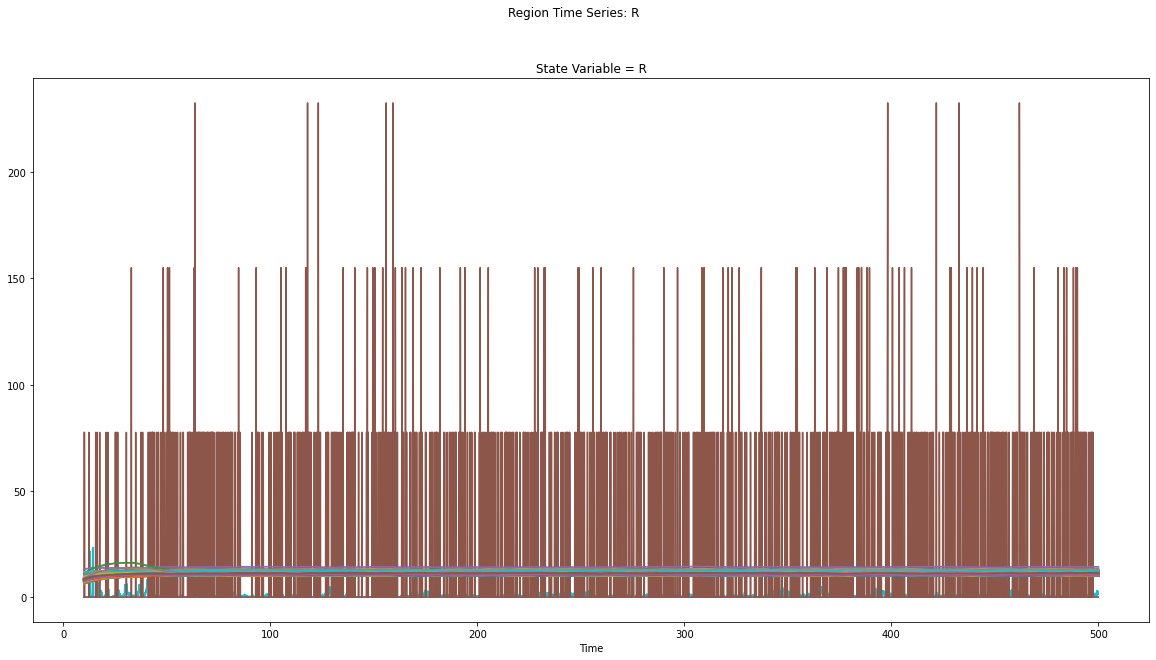

In [21]:
# Plot TVB time series
if source_ts is not None:
    source_ts[10.0:].plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning:
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


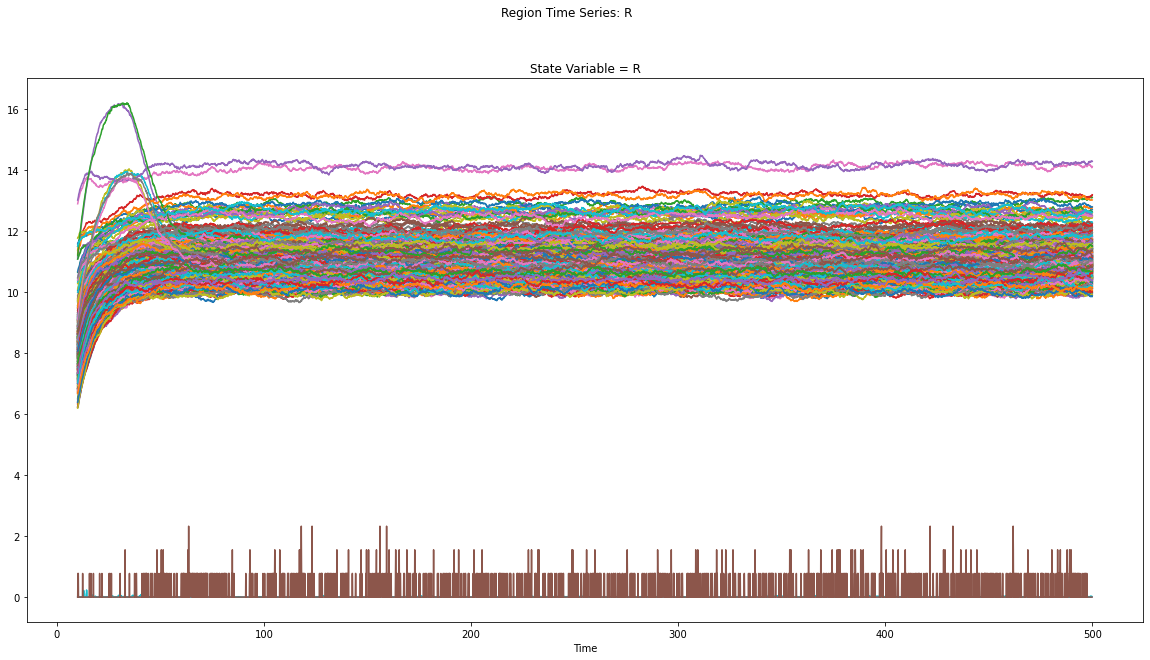

In [22]:
if source_ts is not None:
    source_ts_adj = TimeSeriesXarray()
    source_ts_adj.from_xarray_DataArray(
                              source_ts._data.copy(),
                               connectivity=source_ts.connectivity)
    source_ts_adj.data[:, :, nest_model_builder.spiking_nodes_inds] *= 0.01
    source_ts_adj[10.0:].plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:1047: MatplotlibDeprecationWarning:
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


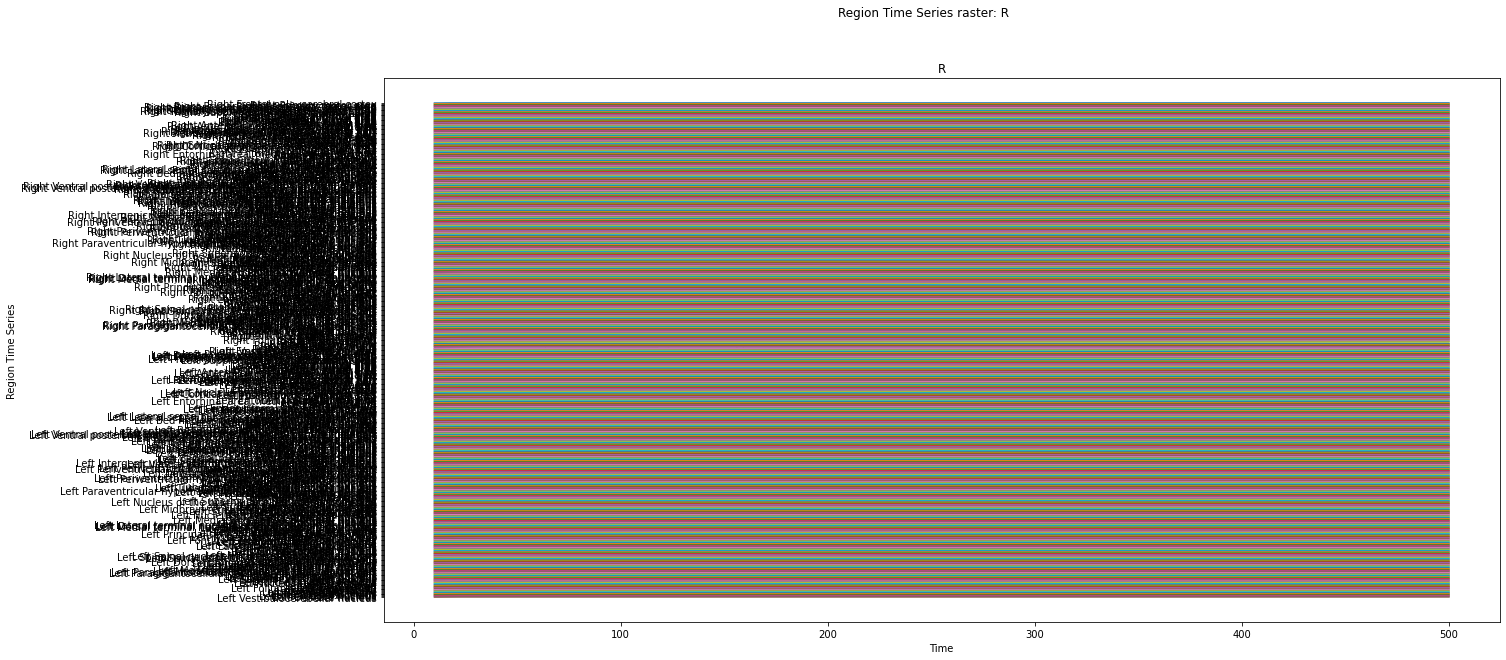

In [23]:
# TVB time series raster plot:
if source_ts is not None and source_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_adj[10.0:].plot_raster(plotter_config=plotter.config, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS,
                          figsize=FIGSIZE);

2021-09-28 19:28:05,669 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning:
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


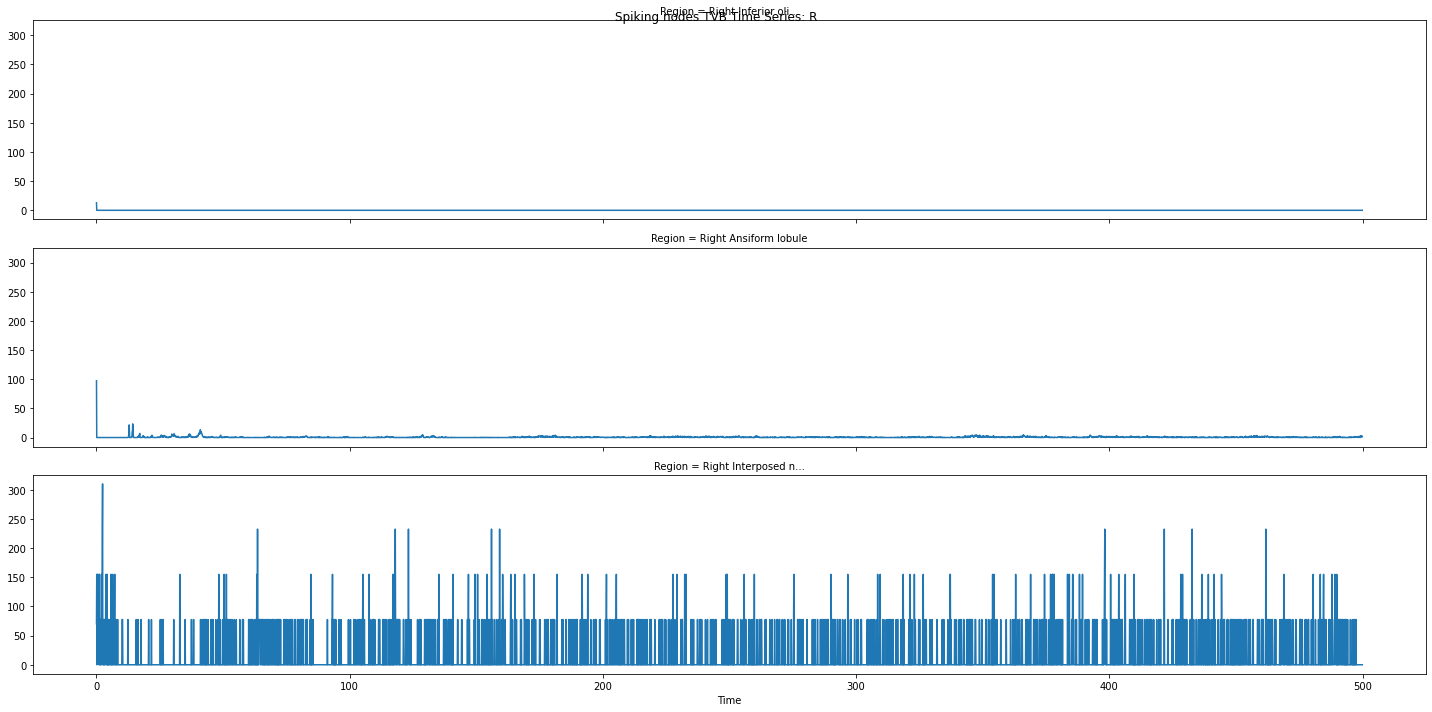

In [24]:
# Focus on the nodes modelled in NEST: 
if source_ts is not None:
    n_spiking_nodes = len(nest_model_builder.spiking_nodes_inds)
    source_ts_nest = source_ts[:, :, nest_model_builder.spiking_nodes_inds]
    source_ts_nest.plot_timeseries(plotter_config=plotter.config, 
                                   hue="Region" if source_ts_nest.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                                   per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS, 
                                   figsize=FIGSIZE, figname="Spiking nodes TVB Time Series");

In [25]:
# Focus on the nodes modelled in NEST: raster plot
if source_ts is not None and source_ts_nest.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_nest.plot_raster(plotter_config=plotter.config, 
                               per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS,
                               figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

### Interactive time series plot

In [26]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)

### Spiking Network plots

In [27]:
from tvb_multiscale.core.data_analysis.spiking_network_analyser import SpikingNetworkAnalyser
# Create a SpikingNetworkAnalyzer:
spikeNet_analyzer = \
    SpikingNetworkAnalyser(spikeNet=nest_network,
                           start_time=0.0, end_time=simulation_length, 
                           period=simulator.monitors[0].period, transient=transient,
                           time_series_output_type="TVB", return_data=True, 
                           force_homogeneous_results=True, connectivity=simulator.connectivity)

### Plot spikes' raster and mean spike rates and correlations

In [28]:
# Spikes rates and correlations per Population and Region
spikes_res = \
    spikeNet_analyzer.\
        compute_spikeNet_spikes_rates_and_correlations(
            populations_devices=None, regions=None,
            rates_methods=[], rates_kwargs=[{}],rate_results_names=[],
            corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
            data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
            return_devices=False
        );

/home/docker/packages/tvb-multiscale/tvb_multiscale/core/utils/file_utils.py:32: UserWarning:genfromtxt: Empty input file: "/home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/cerebellum/outputs/cerebRest/res/nest_recordings/io_cell - Right Inferior olivary complex-31960-0.dat"
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/utils/file_utils.py:32: UserWarning:genfromtxt: Empty input file: "/home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/cerebellum/outputs/cerebRest/res/nest_recordings/io_cell - Right Inferior olivary complex-31960-1.dat"
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/utils/file_utils.py:32: UserWarning:genfromtxt: Empty input file: "/home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/cerebellum/outputs/cerebRest/res/nest_recordings/io_cell - Right Inferior olivary complex-31960-2.dat"
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/utils/file_utils.py:32: UserWarning:genfromtxt: Empty input file: "

<xarray.DataArray "Mean Populations' Spikes' Rates" (Population: 11, Region: 3)>
array([[ 2.41215573,         nan,         nan],
       [ 2.48254239,         nan,         nan],
       [ 1.01259047,         nan,         nan],
       [12.22222217,         nan,         nan],
       [        nan,  0.        ,         nan],
       [17.60919532,         nan,         nan],
       [15.68844585,         nan,         nan],
       [76.42222188,         nan,         nan],
       [        nan,         nan, 13.3621933 ],
       [        nan,         nan,  0.        ],
       [        nan,         nan, 34.45305756]])
Coordinates:
  * Region      (Region) object 'Right Ansiform lobule' ... 'Right Interposed...
  * Population  (Population) object 'mossy_fibers' ... 'dcn_cell_glut_large'
<xarray.DataArray "Populations' Correlation Coefficient" (Population_i: 11, Population_j: 11, Region_i: 3, Region_j: 3)>
array([[[[        nan,         nan,         nan],
         [        nan,         nan,         nan]

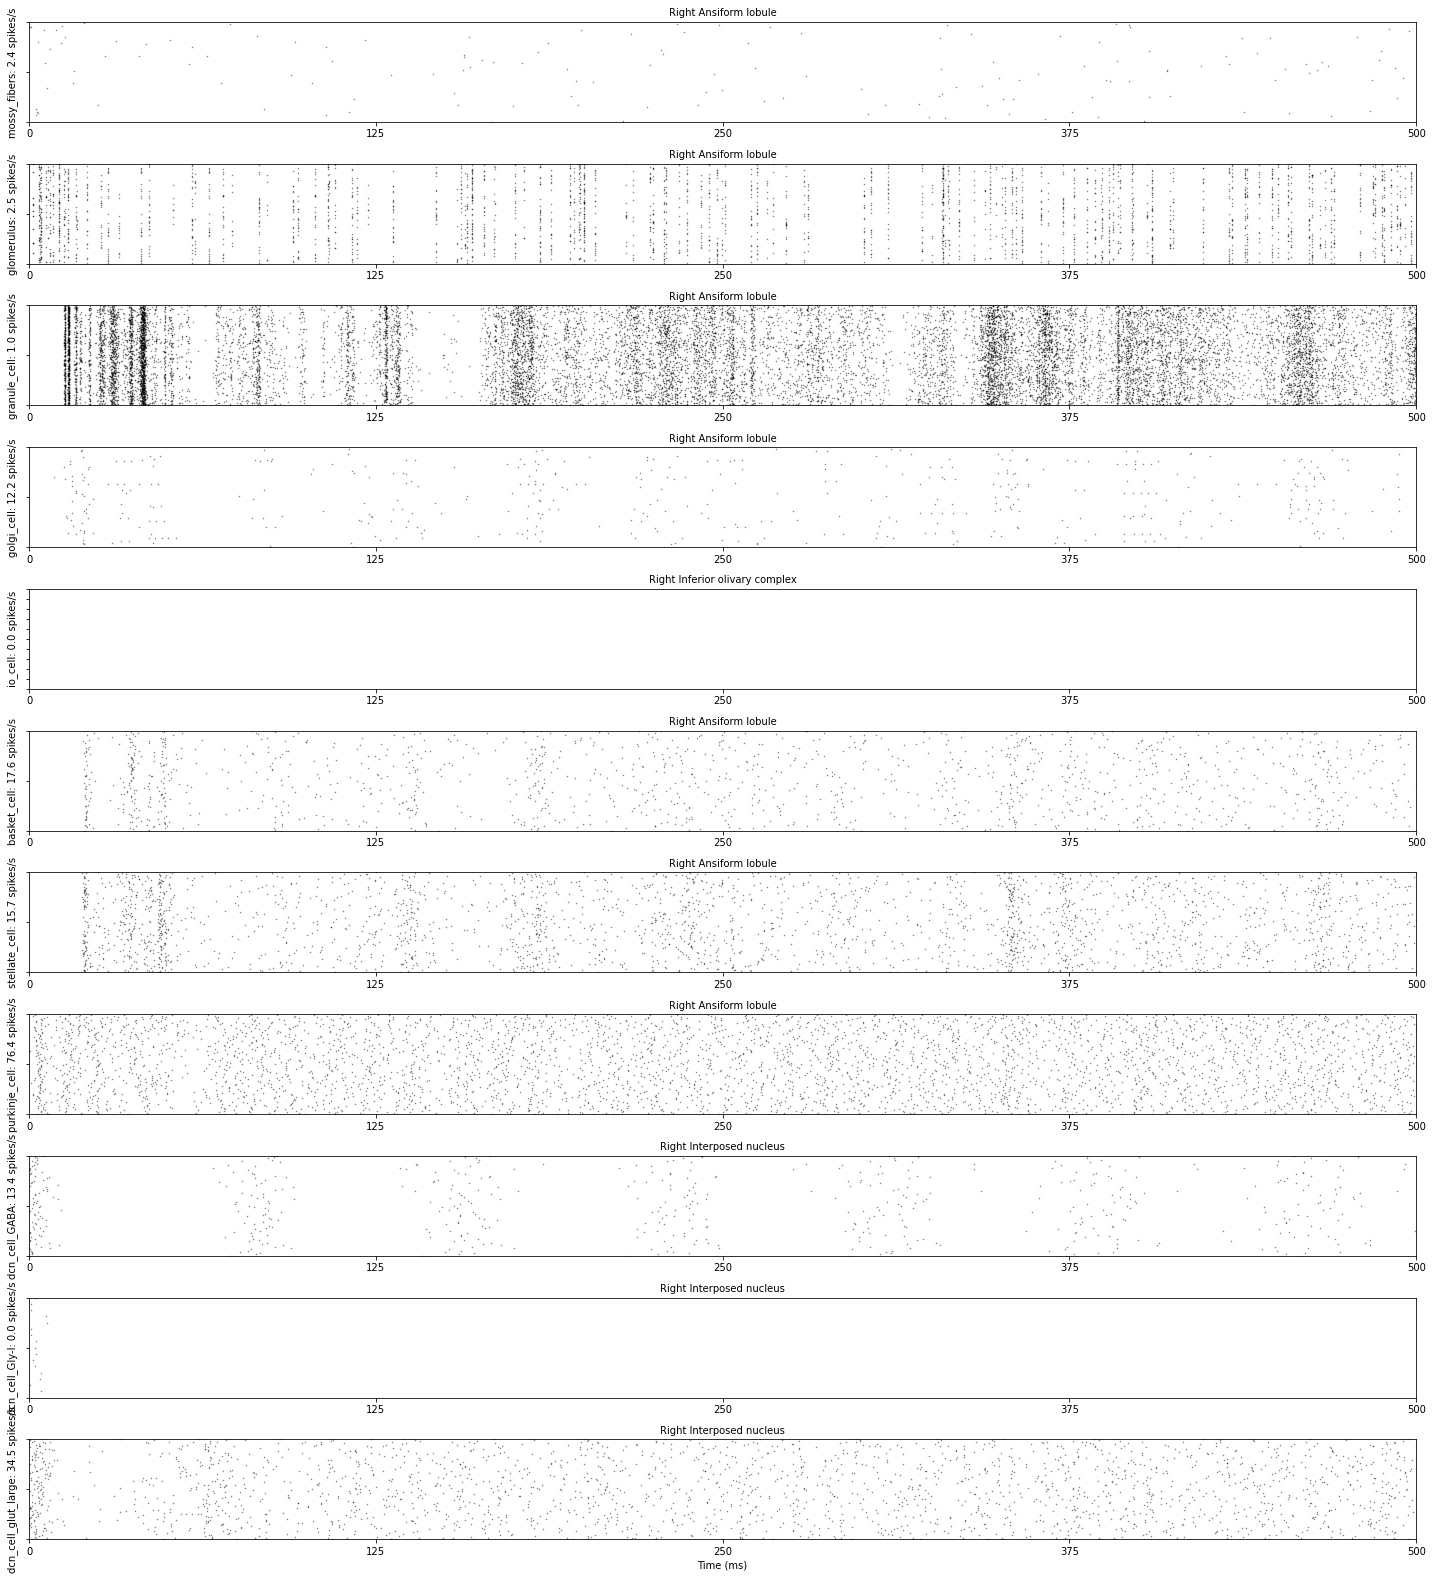

<Figure size 432x288 with 0 Axes>

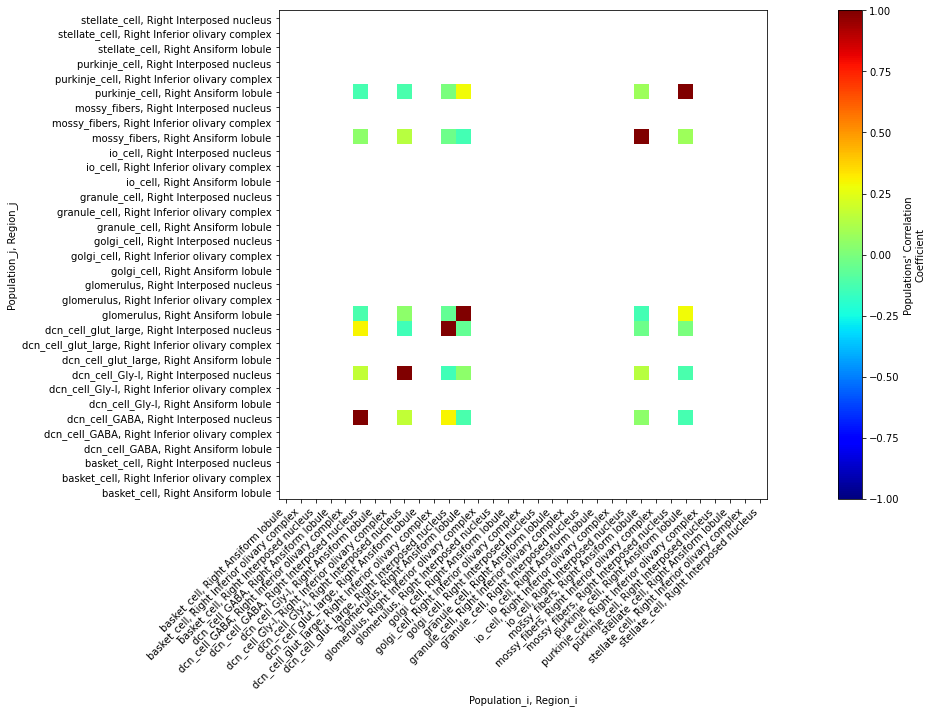

In [29]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.plot_spike_events(spikes_res["spikes"], mean_results=spikes_res["mean_rate"], # time_series=spikes_res["mean_rate_time_series"], 
                                  figsize=(20, 22),  
                                  stimulus=[nest_model_builder.STIM_MF_START, 
                                            nest_model_builder.STIM_IO_START, 
                                            nest_model_builder.STIM_MF_END, 
                                            nest_model_builder.STIM_IO_END] if STIMULUS else None,
                                  stimulus_linewidth=5.0,
                                  spikes_markersize=0.5, spikes_alpha=0.5,
                                  n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                                  time_axis_min=0.0, time_axis_max=simulation_length)
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)

In [30]:
if spikes_res:
    print("Mean spike rates:")
    for pop in spikes_res["mean_rate"].coords["Population"]:
        for reg in spikes_res["mean_rate"].coords["Region"]:
            if not np.isnan(spikes_res["mean_rate"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_res["mean_rate"].loc[pop, reg].values.item()))

    # savemat(os.path.join(config.out.FOLDER_RES, "spikes_mean_rates.mat"), spikes_res["mean_rate"].to_dict())


Mean spike rates:
mossy_fibers - Right Ansiform lobule: 2.41216
glomerulus - Right Ansiform lobule: 2.48254
granule_cell - Right Ansiform lobule: 1.01259
golgi_cell - Right Ansiform lobule: 12.2222
io_cell - Right Inferior olivary complex: 0
basket_cell - Right Ansiform lobule: 17.6092
stellate_cell - Right Ansiform lobule: 15.6884
purkinje_cell - Right Ansiform lobule: 76.4222
dcn_cell_GABA - Right Interposed nucleus: 13.3622
dcn_cell_Gly-I - Right Interposed nucleus: 0
dcn_cell_glut_large - Right Interposed nucleus: 34.4531


In [31]:
spikes_sync = None
# spikeNet_analyzer.resample = True
# spikes_sync = \
#     spikeNet_analyzer.compute_spikeNet_synchronization(populations_devices=None, regions=None,
#                                                        comp_methods=[spikeNet_analyzer.compute_spikes_sync, 
#                                                                      spikeNet_analyzer.compute_spikes_sync_time_series, 
#                                                                      spikeNet_analyzer.compute_spikes_distance, 
#                                                                      spikeNet_analyzer.compute_spikes_distance_time_series,
#                                                                      spikeNet_analyzer.compute_spikes_isi_distance, 
#                                                                      spikeNet_analyzer.compute_spikes_isi_distance_time_series],
#                                                        computations_kwargs=[{}], data_kwargs={},
#                                                        return_spikes_trains=False, return_devices=False)
# # print(spikes_sync)


In [32]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_sync_time_series"], 
                              mean_results=spikes_sync["spikes_sync"], 
                              stistimulus=[nest_model_builder.STIM_MF_START, 
                                           nest_model_builder.STIM_IO_START, 
                                           nest_model_builder.STIM_MF_END, 
                                           nest_model_builder.STIM_IO_END] if STIMULUS else None,
                              stimulus_linewidth=5.0,
                              spikes_markersize=0.5, spikes_alpha=0.5,
                              n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                              time_axis_min=0.0, time_axis_max=simulation_length, figsize=(20, 22)
                              )

In [33]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_distance_time_series"], 
                              mean_results=spikes_sync["spikes_distance"], 
                              stimulus=[nest_model_builder.STIM_MF_START, 
                                        nest_model_builder.STIM_IO_START, 
                                        nest_model_builder.STIM_MF_END, 
                                        nest_model_builder.STIM_IO_END] if STIMULUS else None,
                              stimulus_linewidth=5.0,
                              spikes_markersize=0.5, spikes_alpha=0.5,
                              n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                              time_axis_min=0.0, time_axis_max=simulation_length, figsize=(20, 22)
                                     )

In [34]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_isi_distance_time_series"], 
                              mean_results=spikes_sync["spikes_isi_distance"], 
                              stimulus=[nest_model_builder.STIM_MF_START, 
                                        nest_model_builder.STIM_IO_START, 
                                        nest_model_builder.STIM_MF_END, 
                                        nest_model_builder.STIM_IO_END] if STIMULUS else None,
                              stimulus_linewidth=5.0,
                              spikes_markersize=0.5, spikes_alpha=0.5,
                              n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                              time_axis_min=0.0, time_axis_max=simulation_length, figsize=(20, 22)
                                     )

In [35]:
if spikes_sync:
    print("Spike synchronization:")
    for pop in spikes_sync["spikes_sync"].coords["Population"]:
        for reg in spikes_sync["spikes_sync"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_sync"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_sync"].loc[pop, reg].values.item()))

#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_sync.mat"), spikes_sync["spikes_sync"].to_dict())
#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_sync_time_series.mat"), spikes_sync["spikes_sync_time_series"].to_dict())

In [36]:
if spikes_sync:
    print("Spike distance:")
    for pop in spikes_sync["spikes_distance"].coords["Population"]:
        for reg in spikes_sync["spikes_distance"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_distance"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_distance"].loc[pop, reg].values.item()))

#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_distance.mat"), spikes_sync["spikes_distance"].to_dict())
#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_distance_time_series.mat"), spikes_sync["spikes_distance_time_series"].to_dict())

In [37]:
if spikes_sync:
    print("Spike ISI distance:")
    for pop in spikes_sync["spikes_isi_distance"].coords["Population"]:
        for reg in spikes_sync["spikes_isi_distance"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_isi_distance"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_isi_distance"].loc[pop, reg].values.item()))

#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_isi_distance.mat"), spikes_sync["spikes_isi_distance"].to_dict())
#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_isi_distance_time_series.mat"), spikes_sync["spikes_isi_distance_time_series"].to_dict())

In [38]:
if spikes_res and writer:
    writer.write_object(spikes_res["spikes"].to_dict(), 
                        path=os.path.join(config.out.FOLDER_RES,  "Spikes") + ".h5");
    writer.write_object(spikes_res["mean_rate"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["mean_rate"].name) + ".h5");
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                              spikes_res["mean_rate_time_series"]._data,
                               connectivity=spikes_res["mean_rate_time_series"].connectivity),
                           os.path.join(config.out.FOLDER_RES,
                                        spikes_res["mean_rate_time_series"].title) + ".h5",
                           recursive=False);
    writer.write_object(spikes_res["spikes_correlation_coefficient"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["spikes_correlation_coefficient"].name) + ".h5");

### Get  SpikingNetwork mean field variable time series and plot them

/home/docker/packages/tvb-multiscale/tvb_multiscale/core/utils/file_utils.py:32: UserWarning:genfromtxt: Empty input file: "/home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/cerebellum/outputs/cerebRest/res/nest_recordings/granule_cell_ts - Right Ansiform lobule-31967-0.dat"
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/utils/file_utils.py:32: UserWarning:genfromtxt: Empty input file: "/home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/cerebellum/outputs/cerebRest/res/nest_recordings/granule_cell_ts - Right Ansiform lobule-31967-2.dat"
/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning:
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


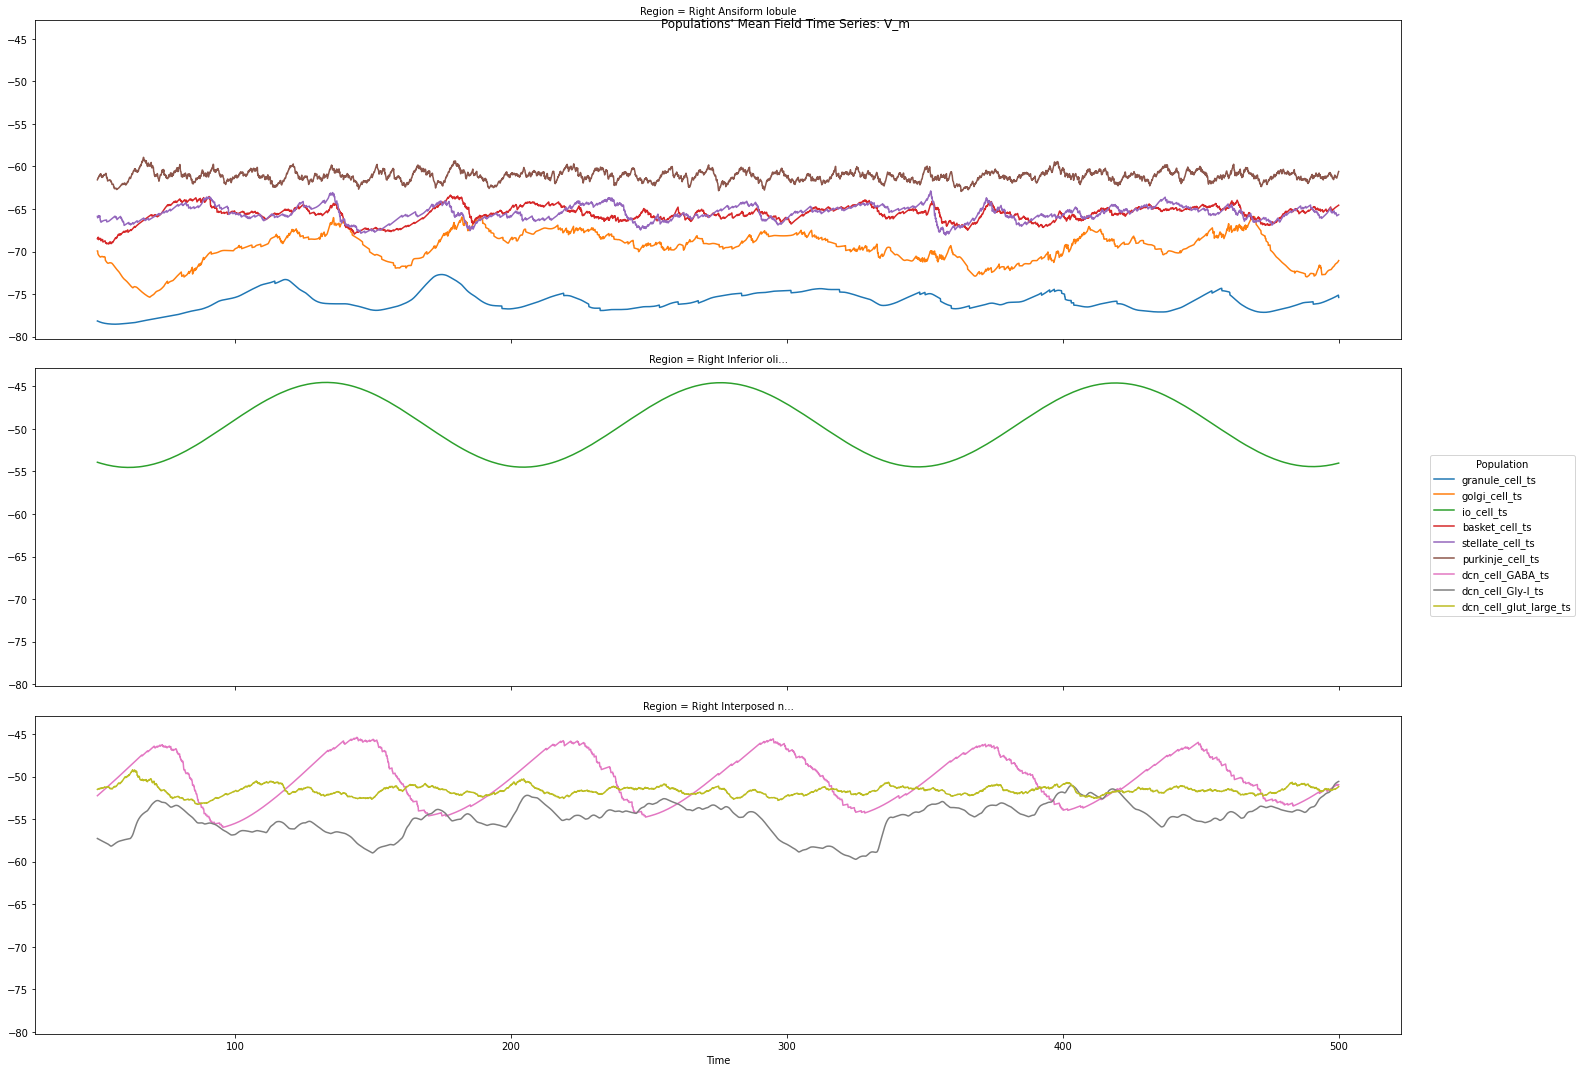

In [39]:
# Continuous time variables' data of spiking neurons
if plot_per_neuron:
    spikeNet_analyzer.return_data = True
else:
    spikeNet_analyzer.return_data = False
spikeNet_ts = \
    spikeNet_analyzer. \
         compute_spikeNet_mean_field_time_series(populations_devices=None, regions=None, variables=None,
                                                 computations_kwargs={}, data_kwargs={}, return_devices=False)
if spikeNet_ts:
    if plot_per_neuron:
        mean_field_ts = spikeNet_ts["mean_field_time_series"]  # mean field
        spikeNet_ts = spikeNet_ts["data_by_neuron"]  # per neuron data
    else:
        mean_field_ts = spikeNet_ts
        spikeNet_ts = None
    if mean_field_ts and mean_field_ts.size > 0:
        mean_field_ts.plot_timeseries(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS)
        if mean_field_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
            mean_field_ts.plot_raster(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS,
                                      linestyle="--", alpha=0.5, linewidth=0.5)
else:
    mean_field_ts = None

In [40]:
# Write results to file:
if mean_field_ts and writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                                       mean_field_ts._data,
                                       connectivity=mean_field_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, mean_field_ts.title) + ".h5", 
                           recursive=False)

### Compute per neuron spikes' rates times series and plot them

In [41]:
if spikes_res and plot_per_neuron:
    from tvb.simulator.plot.base_plotter import pyplot
    spikeNet_analyzer.return_data = False
    rates_ts_per_neuron = \
        spikeNet_analyzer. \
            compute_spikeNet_rates_time_series(populations_devices=None, regions=None,
                                               computations_kwargs={}, data_kwargs={},
                                               return_spikes_trains=False, return_devices=False);
    if rates_ts_per_neuron is not None and rates_ts_per_neuron.size:
        # Regions in rows
        row = rates_ts_per_neuron.dims[2] if rates_ts_per_neuron.shape[2] > 1 else None
        if row is None:
            # Populations in rows
            row = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
            col = None
        else:
            # Populations in columns
            col = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
        pyplot.figure()
        rates_ts_per_neuron.plot(y=rates_ts_per_neuron.dims[3], row=row, col=col, cmap="jet")
        plotter.base._save_figure(figure_name="Spike rates per neuron")
        # del rates_ts_per_neuron # to free memory

### Plot per neuron SpikingNetwork time series

In [42]:
# Regions in rows
if spikeNet_ts is not None and spikeNet_ts.size:
    row = spikeNet_ts.dims[2] if spikeNet_ts.shape[2] > 1 else None
    if row is None:
        # Populations in rows
        row = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
        col = None
    else:
        # Populations in cols
         col = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
    for var in spikeNet_ts.coords[spikeNet_ts.dims[1]]:
        this_var_ts = spikeNet_ts.loc[:, var, :, :, :]
        this_var_ts.name = var.item()
        pyplot.figure()
        this_var_ts.plot(y=spikeNet_ts.dims[4], row=row, col=col, cmap="jet", figsize=FIGSIZE)
        plotter.base._save_figure(
            figure_name="Spiking Network variables' time series per neuron: %s" % this_var_ts.name)
    del spikeNet_ts # to free memory

In [43]:
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Get spike events for each recording device - the neural populations that you decided not to record will have empty spike detectors
GoCspikes = nest_network.output_devices["golgi_cell"][0].get_events()
goc_evs = GoCspikes['senders']
goc_ts = GoCspikes['times']

GrCspikes = nest_network.output_devices["granule_cell"][0].get_events()
grc_evs = GrCspikes['senders']
grc_ts = GrCspikes['times']

Glomspikes = nest_network.output_devices["glomerulus"][0].get_events()
glom_evs = Glomspikes['senders']
glom_ts = Glomspikes['times']

Purkinjespikes = nest_network.output_devices["purkinje_cell"][0].get_events()
pc_evs = Purkinjespikes['senders']
pc_ts = Purkinjespikes['times']

Basketspikes = nest_network.output_devices["basket_cell"][0].get_events()
bc_evs = Basketspikes['senders']
bc_ts = Basketspikes['times']

Stellatespikes = nest_network.output_devices["stellate_cell"][0].get_events()
sc_evs = Stellatespikes['senders']
sc_ts = Stellatespikes['times']

DCNspikes = nest_network.output_devices["dcn_cell_glut_large"][0].get_events()
dcn_evs = DCNspikes['senders']
dcn_ts = DCNspikes['times']

Outputspikes = DCNspikes
output_evs = Outputspikes['senders']
output_ts = Outputspikes['times']

IOspikes = nest_network.output_devices["io_cell"][0].get_events()
io_evs = IOspikes['senders']
io_ts = IOspikes['times']


/home/docker/packages/tvb-multiscale/tvb_multiscale/core/utils/file_utils.py:32: UserWarning:

genfromtxt: Empty input file: "/home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/cerebellum/outputs/cerebRest/res/nest_recordings/io_cell - Right Inferior olivary complex-31960-0.dat"

/home/docker/packages/tvb-multiscale/tvb_multiscale/core/utils/file_utils.py:32: UserWarning:

genfromtxt: Empty input file: "/home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/cerebellum/outputs/cerebRest/res/nest_recordings/io_cell - Right Inferior olivary complex-31960-1.dat"

/home/docker/packages/tvb-multiscale/tvb_multiscale/core/utils/file_utils.py:32: UserWarning:

genfromtxt: Empty input file: "/home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/cerebellum/outputs/cerebRest/res/nest_recordings/io_cell - Right Inferior olivary complex-31960-2.dat"

/home/docker/packages/tvb-multiscale/tvb_multiscale/core/utils/file_utils.py:32: UserWarning:

genfromtxt: Empty in

### Raster Plot 

Below, a raster plot of cell spikes for each cell type can be displayed; select the cell type modifying the CELL_TO_PLOT variable.
Cell types are:
1. 'granule'
2. 'golgi'
3. 'purkinje'
4. 'stellate'
5. 'basket'
6. 'dcn'

For Purkinje and DCN neurons, you can specify the microzone you want to analyze: microzone 1 is receiving both CS and US, while microzone 2 receives only CS (empty lines in raster plots would represent neurons of the other microzone). In the first case, US triggers burst-pause and pause-burst mechanisms, which are fundamental to fine tune the timing of cerebellar motor outputs.

Attention: you can plot only the activity of cell types whose recording device were connected before the simulation run!

In [44]:
CELL_TO_PLOT = 'dcn_cell_glut_large'

cells = {'granule_cell': [grc_ts, grc_evs],
         'golgi_cell': [goc_ts, goc_evs],
         'glomerulus': [glom_ts, glom_evs],
         'purkinje_cell': [pc_ts, pc_evs],
         'stellate_cell': [sc_ts, sc_evs],
         'basket_cell': [bc_ts, bc_evs],
         'dcn_cell_glut_large': [dcn_ts, dcn_evs],
         'output':[output_ts, output_evs],
         'io_cell':[io_ts, io_evs]}


color = {'granule_cell': 'rgba(255, 0, 0, .8)',
         'golgi_cell': 'rgba(0, 255, 0, .8)',
         'glomerulus': 'rgba(0, 0, 0, .8)',
         'purkinje_cell': 'rgba(0, 0, 0, .8)',
         'stellate_cell': 'rgba(234, 10, 142, .8)',
         'basket_cell': 'rgba(234, 10, 142, .8)',
         'output': 'rgba(0, 0, 0, .8)',
         'dcn_cell_glut_large': 'rgba(0, 0, 0, .8)',
         'io_cell': 'rgba(255, 127, 80, .8)'}

times = cells[CELL_TO_PLOT][0]
cell_ids = cells[CELL_TO_PLOT][1]
   
    
    
trace0 = go.Scatter(
    x = times,
    y = cell_ids,
    name = '',
    mode = 'markers',
    marker = dict(
        size = 4,
        color = color[CELL_TO_PLOT],
        line = dict(
            width = .2,
            color = 'rgb(0, 0, 0)'
        )
    )
)

data = [trace0]

layout = go.Layout(
              title = 'Spikes raster plot',
              yaxis = dict(title='Neuron GID', zeroline = False),
              xaxis = dict(title='Time [msecs]', zeroline = False, range=[0,nest_model_builder.TOT_DURATION+100]),
              shapes= [
              # Line STIM to MFs start
              {
                  'type': 'line',
                  'x0': nest_model_builder.STIM_MF_START,
                  'y0': np.amin(cell_ids),
                  'x1': nest_model_builder.STIM_MF_START,
                  'y1': np.amax(cell_ids),
                  'line': {
                      'color': 'rgb(55, 128, 191)',
                      'width': 2,
                  }
               },
               # Line STIM to MFs stop
               {
                  'type': 'line',
                  'x0': nest_model_builder.STIM_MF_END,
                  'y0': np.amin(cell_ids),
                  'x1': nest_model_builder.STIM_MF_END,
                  'y1': np.amax(cell_ids),
                  'line': {
                      'color': 'rgb(55, 128, 191)',
                      'width': 2,
                  }
               }]
             )

fig = go.Figure(data=data, layout=layout)
fig.update_xaxes(range=[70.0, 370.0])
iplot(fig, filename='styled-scatter')

### PSTH plot of spikes 

Define the function to extract spike histograms

In [45]:
def metrics(spikeData, TrialDuration, neurons):
    id_spikes = np.sort(np.unique(spikeData,return_index=True))
    bin_size = 5   # [ms]
    n_bins = int(TrialDuration/bin_size) + 1
    psth, tms = np.histogram(spikeData, bins = n_bins, range = (0 , TrialDuration))
    freq = [i/(len(neurons)*(bin_size/1000)) for i in psth]
    
    # absolute frequency
    abs_freq = np.zeros(id_spikes[0].shape[0])
    for idx,i in enumerate(id_spikes[0]):
        count = np.where(spikeData==i)[0]
        abs_freq[idx] = count.shape[0]
    
    # mean frequency
    m_f = (id_spikes[0].shape[0])/TrialDuration
    
    # graph using plotly
    data = [
        go.Bar(
        x = tms[0:len(tms)-1],
        y = freq,
        width = 4.0,
        marker=dict(
            color=color[CELL_TO_PLOT])
        )]
    
    layout = go.Layout(
            scene = dict(aspectmode='data'),
            xaxis={'title':'time (ms)'}, 
            yaxis={'title':'number of spikes'},
            shapes= [
            # Line STIM start
            {
                'type': 'line',
                'x0': nest_model_builder.STIM_MF_START,
                'y0': 0,
                'x1': nest_model_builder.STIM_MF_START,
                'y1': np.amax(freq)+10,
                'line': {
                    'color': 'rgb(55, 128, 191)',
                    'width': 2,
                }
            },
            # Line STIM stop
            {
                'type': 'line',
                'x0': nest_model_builder.STIM_MF_END,
                'y0': 0,
                'x1': nest_model_builder.STIM_MF_END,
                'y1': np.amax(freq)+10,
                'line': {
                    'color': 'rgb(55, 128, 191)',
                    'width': 2,
                }
            }]
    )
    
    fig = go.Figure(data=data, layout=layout)
    fig.update_xaxes(range=[70.0, 370.0])
    iplot(fig, filename='psth')
    
    

    print("absolute frequency: ", abs_freq)
    print("mean frequency: ", m_f)
    
    return tms

<div align=justify>Plot the histogram of spikes. 
For all cell type you can observe an increased firing rate during the Conditioned Stimulus, whose amount depends on the balance between excitatory and inhibitory input received by that neural population. For neurons receiving also the Unconditioned Stimulus through Inferior Olive connections, you can observe pause and/or bursting responses, resulting from E-GLIF dynamics and network topology. For Molecular Layer Interneurons, the spillover-mediated connections from Inferior Olive cause a delayed increase of firing rate following the US.</div>

In [46]:
metrics(times, simulation_length, # neurons to plot same as CELL_TO_PLOT:
        nest_network.brain_regions['Right Interposed nucleus']['dcn_cell_glut_large'].neurons) 

absolute frequency:  [2. 1. 2. ... 1. 1. 1.]
mean frequency:  3.876


array([  0.        ,   4.95049505,   9.9009901 ,  14.85148515,
        19.8019802 ,  24.75247525,  29.7029703 ,  34.65346535,
        39.6039604 ,  44.55445545,  49.5049505 ,  54.45544554,
        59.40594059,  64.35643564,  69.30693069,  74.25742574,
        79.20792079,  84.15841584,  89.10891089,  94.05940594,
        99.00990099, 103.96039604, 108.91089109, 113.86138614,
       118.81188119, 123.76237624, 128.71287129, 133.66336634,
       138.61386139, 143.56435644, 148.51485149, 153.46534653,
       158.41584158, 163.36633663, 168.31683168, 173.26732673,
       178.21782178, 183.16831683, 188.11881188, 193.06930693,
       198.01980198, 202.97029703, 207.92079208, 212.87128713,
       217.82178218, 222.77227723, 227.72277228, 232.67326733,
       237.62376238, 242.57425743, 247.52475248, 252.47524752,
       257.42574257, 262.37623762, 267.32673267, 272.27722772,
       277.22772277, 282.17821782, 287.12871287, 292.07920792,
       297.02970297, 301.98019802, 306.93069307, 311.88

# References

1 Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide, <br>
  Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>